Wine Type and Classification

Problem statement:
    
    Follow CRISP-DM model to predict 
        if each wine sample is a red or white wine
        the quality of each wine sample, which can be low, medium or high
        
Attributes:

    Input variables:
    
    1-fixed acidity
    2-volatile acidity
    3-citrix acid
    4-residual sugars
    5-chlorides
    6-free sulfur dioxide
    7-total sulfur dioxide
    8-density
    9-pH
    10-sulphates
    11-alcohol
    
    Output variables:
    
    quality -score between 0 to 10

###### Table of Contents

    1  Preparing environment and uploading data
        1.1  Import Packages
        1.2  Load Dataset
    2  Exploratory Data Analysis (EDA)
        2.1  Take a First Look of our Data:
        2.2  Nulls Check and Cleaning
        2.3  Understanding Wine and Types
        
        2.5  Descriptive Statistics
            2.5.1  By Type
            2.5.2  By Quality
        2.6  Inferential Statistics
        2.7  Check for any correlations between features
            2.7.1  Check for correlations based on wines types
            2.7.2  Check for correlations based on wines quality labels
    3  Data Engineering - Cleaning, Transforming, Selection and Reduction
        3.1  Box cox transformation of highly skewed features
        3.2  Identify and treat multicollinearity:
        3.3  Feature Selection into the Pipeline
        3.4  Dimensionality Reduction
            3.4.1  PCA
            3.4.2  Linear Discriminant Analysis (LDA)
    4  Modeling
        4.1  Simplify Get Results
        4.2  Hyper Parametrization
        4.3  Wine Type Classifier Models:
            4.3.1  Logistic Regression
            4.3.2  Deep Neural Network
        4.4  Wine Quality Classifier Models:
            4.4.1  Decision Tree Classifier
            4.4.2  Ensemble models
            4.4.3  Random Forest Classifier
            4.4.4  XGBoost (eXtreme Gradient Boosting)
            4.4.5  KNeighbors Classifier
            4.4.6  Gradient Boosting for Classification
            4.4.7  AdaBoost classifier
            4.4.8  Logistic Regression
            4.4.9  Linear Support Vector Classification
        4.5  Check the best results from the models hyper parametrization
        4.6  Make Staked Classifier
    5  Conclusion
    6  Next steps
    7  Bonus Task:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pylab

from scipy.stats import skew, norm, probplot, boxcox, f_oneway
from sklearn.base import BaseEstimator, TransformerMixin, clone, ClassifierMixin

from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler, PolynomialFeatures, MinMaxScaler

from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, cross_val_predict, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier

Load the dataset, create quality label based on the quality score according to:
    
    low for less or equal to 5
    medium for between 6 and 7
    high for more than 7

In [2]:
wines = pd.read_csv(r'winequality.csv')
wines['qual_labels'] = wines.quality.apply(lambda x: 'low' if x<=5 else 'medium' if x<=7 else 'high')

#reshuffle records just to randomize datapoints
wines = wines.sample(frac=1, random_state=101).reset_index(drop=True)

###### Exploratory Data Analysis

In [3]:
wines.head()

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  white            7.3              0.28         0.42            14.4   
1    red            6.9              1.09         0.06             2.1   
2    red            9.5              0.46         0.24             2.7   
3    red            8.2              0.31         0.40             2.2   
4  white            7.9              0.28         0.41             4.9   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.040                 49.0                 173.0  0.99940  3.28   
1      0.061                 12.0                  31.0  0.99480  3.51   
2      0.092                 14.0                  44.0  0.99800  3.12   
3      0.058                  6.0                  10.0  0.99536  3.31   
4      0.058                 31.0                 153.0  0.99660  3.27   

   sulphates  alcohol  quality qual_labels  
0       0.82      9.0        7      medium  
1       0.43     11.4        4         low  
2       0.74     10.0        6      medium  
3       0.68     11.2        7      medium  
4       0.51      9.7        6      medium

In [4]:
wines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
 13  qual_labels           6497 non-null   object 
dtypes: float64(11), int64(1), object(2)
memory usage: 710.7+ KB


In [5]:
wines.columns

Index(['type', 'fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'quality', 'qual_labels'],
      dtype='object')

In [6]:
wines.columns = ['type', 'fixed_acidity', 'volatile_acidity', 'citric_acid',
       'residual_sugar', 'chlorides', 'free_sulfur_dioxide',
       'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'quality', 'qual_labels']

In [7]:
wines.tail()

type  fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
6492  white            6.9              0.19         0.40             1.4   
6493    red            9.3              0.37         0.44             1.6   
6494  white            6.0              0.13         0.28             5.7   
6495  white            6.7              0.30         0.49             4.8   
6496    red            7.7              0.69         0.49             1.8   

      chlorides  free_sulfur_dioxide  total_sulfur_dioxide  density    pH  \
6492      0.036                 14.0                  55.0  0.99090  3.08   
6493      0.038                 21.0                  42.0  0.99526  3.24   
6494      0.038                 56.0                 189.5  0.99480  3.59   
6495      0.034                 36.0                 158.0  0.99450  3.12   
6496      0.115                 20.0                 112.0  0.99680  3.21   

      sulphates  alcohol  quality qual_labels  
6492       0.68     11.5        7      medium  
6493       0.81     10.8        7      medium  
6494       0.43     10.6        7      medium  
6495       0.45      9.9        6      medium  
6496       0.71      9.3        5         low

In [8]:
wines.isna().sum()

type                     0
fixed_acidity           10
volatile_acidity         8
citric_acid              3
residual_sugar           2
chlorides                2
free_sulfur_dioxide      0
total_sulfur_dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
qual_labels              0
dtype: int64

In [9]:
wines.qual_labels.value_counts()

medium    3915
low       2384
high       198
Name: qual_labels, dtype: int64

In [10]:
wines.dropna().qual_labels.value_counts()

medium    3894
low       2372
high       197
Name: qual_labels, dtype: int64

If we are to drop missing null values then we will lose 12 in low, 1 in high and 21 in medium category, so lets drop the values

In [11]:
wines.dropna(inplace=True)

In [12]:
wines.shape

(6463, 14)

Lets see how the quality of wines is distributed

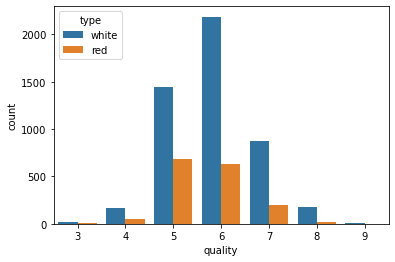

In [13]:
sns.countplot(wines.quality, hue=wines.type)

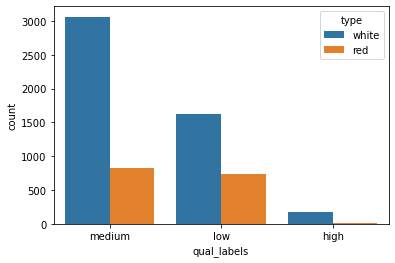

In [14]:
sns.countplot(wines.qual_labels, hue=wines.type)

###### Descriptive Statistics

In [15]:
cols = wines.columns
rs = round(wines.loc[wines.type=='red', cols].describe(),2)
ws = round(wines.loc[wines.type == 'white', cols].describe(),2)
pd.concat([rs, ws], axis=0, keys=['Red wine stats', 'white wine stats']).T

Red wine stats                                           \
                              count   mean    std   min    25%    50%    75%   
fixed_acidity                1593.0   8.33   1.74  4.60   7.10   7.90   9.20   
volatile_acidity             1593.0   0.53   0.18  0.12   0.39   0.52   0.64   
citric_acid                  1593.0   0.27   0.19  0.00   0.09   0.26   0.42   
residual_sugar               1593.0   2.54   1.41  0.90   1.90   2.20   2.60   
chlorides                    1593.0   0.09   0.05  0.01   0.07   0.08   0.09   
free_sulfur_dioxide          1593.0  15.84  10.44  1.00   7.00  14.00  21.00   
total_sulfur_dioxide         1593.0  46.46  32.91  6.00  22.00  38.00  62.00   
density                      1593.0   1.00   0.00  0.99   1.00   1.00   1.00   
pH                           1593.0   3.31   0.15  2.74   3.21   3.31   3.40   
sulphates                    1593.0   0.66   0.17  0.33   0.55   0.62   0.73   
alcohol                      1593.0  10.42   1.07  8.40   9.50  10.20  11.10   
quality                      1593.0   5.64   0.81  3.00   5.00   6.00   6.00   

                             white wine stats                               \
                         max            count    mean    std   min     25%   
fixed_acidity          15.90           4870.0    6.86   0.84  3.80    6.30   
volatile_acidity        1.58           4870.0    0.28   0.10  0.08    0.21   
citric_acid             1.00           4870.0    0.33   0.12  0.00    0.27   
residual_sugar         15.50           4870.0    6.39   5.07  0.60    1.70   
chlorides               0.61           4870.0    0.05   0.02  0.01    0.04   
free_sulfur_dioxide    72.00           4870.0   35.32  17.01  2.00   23.00   
total_sulfur_dioxide  289.00           4870.0  138.34  42.49  9.00  108.00   
density                 1.00           4870.0    0.99   0.00  0.99    0.99   
pH                      4.01           4870.0    3.19   0.15  2.72    3.09   
sulphates               2.00           4870.0    0.49   0.11  0.22    0.41   
alcohol                14.90           4870.0   10.52   1.23  8.00    9.50   
quality                 8.00           4870.0    5.88   0.89  3.00    5.00   

                                              
                         50%     75%     max  
fixed_acidity           6.80    7.30   14.20  
volatile_acidity        0.26    0.32    1.10  
citric_acid             0.32    0.39    1.66  
residual_sugar          5.20    9.90   65.80  
chlorides               0.04    0.05    0.35  
free_sulfur_dioxide    34.00   46.00  289.00  
total_sulfur_dioxide  134.00  167.00  440.00  
density                 0.99    1.00    1.04  
pH                      3.18    3.28    3.82  
sulphates               0.47    0.55    1.08  
alcohol                10.40   11.40   14.20  
quality                 6.00    6.00    9.00

Highlights from descriptive stats:
1. Mean residual sugar and total sulfur dioxide content in white wine seems to be much higher than red wine.
2. Mean value of sulphates, fixed acidity and volatile acidity seem to be higher in red wine as compared to white wine.
3. In general, white wines has half concentrations of chlorides then red wines.
4. citric acid is more present in white than red wines.

In [16]:
cols = wines.columns
ls = round(wines[wines.qual_labels=='low'] [cols].describe(),2)
ms = round(wines[wines.qual_labels=='medium'] [cols].describe(),2)
hs = round(wines[wines.qual_labels=='high'] [cols].describe(),2)
pd.concat([ls, ms, hs], axis=1, keys=['Low Quality wine', 'medium quality wine', 'high quality wine']).T

count    mean    std    min    25%  \
Low Quality wine    fixed_acidity         2372.0    7.33   1.27   4.20   6.50   
                    volatile_acidity      2372.0    0.40   0.19   0.10   0.26   
                    citric_acid           2372.0    0.30   0.16   0.00   0.21   
                    residual_sugar        2372.0    5.63   4.91   0.60   1.80   
                    chlorides             2372.0    0.06   0.04   0.01   0.04   
                    free_sulfur_dioxide   2372.0   29.48  19.86   2.00  14.00   
                    total_sulfur_dioxide  2372.0  119.21  61.90   6.00  68.00   
                    density               2372.0    1.00   0.00   0.99   0.99   
                    pH                    2372.0    3.21   0.16   2.74   3.11   
                    sulphates             2372.0    0.52   0.14   0.25   0.44   
                    alcohol               2372.0    9.87   0.84   8.00   9.30   
                    quality               2372.0    4.88   0.36   3.00   5.00   
medium quality wine fixed_acidity         3894.0    7.17   1.32   3.80   6.40   
                    volatile_acidity      3894.0    0.31   0.14   0.08   0.21   
                    citric_acid           3894.0    0.33   0.13   0.00   0.26   
                    residual_sugar        3894.0    5.33   4.69   0.70   1.80   
                    chlorides             3894.0    0.05   0.03   0.01   0.04   
                    free_sulfur_dioxide   3894.0   30.94  16.34   1.00  19.00   
                    total_sulfur_dioxide  3894.0  113.45  53.57   6.00  81.00   
                    density               3894.0    0.99   0.00   0.99   0.99   
                    pH                    3894.0    3.22   0.16   2.72   3.11   
                    sulphates             3894.0    0.54   0.15   0.22   0.43   
                    alcohol               3894.0   10.81   1.20   8.40   9.80   
                    quality               3894.0    6.28   0.45   6.00   6.00   
high quality wine   fixed_acidity          197.0    6.85   1.15   3.90   6.20   
                    volatile_acidity       197.0    0.29   0.12   0.12   0.21   
                    citric_acid            197.0    0.33   0.10   0.03   0.28   
                    residual_sugar         197.0    5.37   4.16   0.80   2.00   
                    chlorides              197.0    0.04   0.02   0.01   0.03   
                    free_sulfur_dioxide    197.0   34.53  17.12   3.00  24.00   
                    total_sulfur_dioxide   197.0  117.70  41.69  12.00  96.00   
                    density                197.0    0.99   0.00   0.99   0.99   
                    pH                     197.0    3.22   0.16   2.88   3.13   
                    sulphates              197.0    0.51   0.16   0.25   0.38   
                    alcohol                197.0   11.69   1.27   8.50  11.00   
                    quality                197.0    8.03   0.16   8.00   8.00   

                                             50%     75%     max  
Low Quality wine    fixed_acidity           7.10    7.80   15.90  
                    volatile_acidity        0.34    0.50    1.58  
                    citric_acid             0.30    0.40    1.00  
                    residual_sugar          2.90    8.50   23.50  
                    chlorides               0.05    0.08    0.61  
                    free_sulfur_dioxide    26.00   42.00  289.00  
                    total_sulfur_dioxide  124.00  167.00  440.00  
                    density                 1.00    1.00    1.00  
                    pH                      3.20    3.31    3.90  
                    sulphates               0.50    0.58    2.00  
                    alcohol                 9.60   10.40   14.90  
                    quality                 5.00    5.00    5.00  
medium quality wine fixed_acidity           6.90    7.60   15.60  
                    volatile_acidity        0.27    0.36    1.04  
                    citric_acid         

Highlights from descriptive statisct of quality perspective above:

1.    It is interesting how alcohol does not give us much variation to distinguish whether the vine is white or red, but it makes a lot of difference in quality. Note that the higher the quality the higher the average alcohol concentration, increased by about 1% at each level. Although lower quality wines have the lowest standard deviation.
2.    The chlorides and volatile acidity are less present and presented smaller standard deviation in wines of higher quality.
3.    The free sulfur dioxide is higher with higher quality, but their standard deviation decrease with the increase the quality.
4.    Higher quality has less fixed acidity, but the standard deviation is slightly higher in mean quality


###### Inferential statistics

Definition: Inferential statistics is a statistical method that deduces from a small but representative sample the characteristics of a bigger population. In other words, it allows the researcher to make assumptions about a wider group, using a smaller portion of that group as a guideline.

Inferential statistics is one of the two statistical methods employed to analyze data, along with descriptive statistics. The goal of this tool is to provide measurements that can describe the overall population of a research project by studying a smaller representative sample of it.

This way the researcher can make assumptions about key elements with a fair degree of confidence. Among these inferential tools we have regression models, normal distributions and R-squared analysis, among others. The study of the smaller sample can be used to explain the variable’s overall behavior from a whole-population perspective which opens the path for theories and new hypothesis.

The idea is to use statistical methods and models to draw statistical inferences from a given hypotheses. Each hypothesis consists of a null hypothesis and an alternative hypothesis. Based on statistical test results, if the result is statistically significant based on pre-set significance levels (e.g., if obtained p-value is less than 5% significance level), we reject the null hypothesis in favor of the alternative hypothesis. Otherwise, if the results is not statistically significant, we conclude that our null hypothesis was correct.

A great statistical model to prove or disprove the difference in mean among subsets of data is to use the one-way ANOVA test. ANOVA stands for “analysis of variance,” which is a nifty statistical model and can be used to analyze statistically significant differences among means or averages of various groups. This is basically achieved using a statistical test that helps us determine whether or not the means of several groups are equal.

The alternative hypotheses, HA, tells us that there exists at least two group means that are statistically significantly different from each other. Usually the F-statistic and the associated p-value from it is used to determine the statistical significance. Typically a p-value less than 0.05 is taken to be a statistically significant result where we reject the null hypothesis in favor of the original.

So let's evaluate the hypotheses of each of our previous highlights through the statistical inference test

In [17]:
def type_inf_stat_test(feature):
    F, p = f_oneway(wines[wines.type == 'red'][feature],
                   wines[wines.type == 'white'][feature])
    
    if p <= 0.05:
        msg = 'Reject'
    else:
        msg = 'Accept'
    print('F statistic: {:.2f} \tp-value: {:.3f} \tNull Hypothesis: {}'.format(F, p, msg))
    
def quality_inf_stat_test(feature):
    F, p =f_oneway(wines[wines.qual_labels == 'low'][feature],
                  wines[wines.qual_labels == 'medium'][feature],
                  wines[wines.qual_labels == 'high'][feature])
    
    if p<=0.05:
        msg = 'Reject'
    else:
        msg = 'Accept'
    print('F statistic: {:.2f} \tp-value: {:.3f} \tNull Hypothesis: {}'.format(F, p, msg))

In [18]:
print('ANOVA test across wine samples with different wine types:\n')
# - Mean residual sugar and total sulfur dioxide content in white wine seems to be much higher than red wine.
type_inf_stat_test('residual_sugar')
type_inf_stat_test('total_sulfur_dioxide')

ANOVA test across wine samples with different wine types:

F statistic: 898.19 	p-value: 0.000 	Null Hypothesis: Reject
F statistic: 6225.78 	p-value: 0.000 	Null Hypothesis: Reject


In [19]:
#- Mean value of sulphates, fixed acidity and volatile acidity seem to be higher in red wine as compared to white wine.
type_inf_stat_test('sulphates')
type_inf_stat_test('fixed_acidity')
type_inf_stat_test('volatile_acidity')

F statistic: 2005.69 	p-value: 0.000 	Null Hypothesis: Reject
F statistic: 2025.60 	p-value: 0.000 	Null Hypothesis: Reject
F statistic: 4812.72 	p-value: 0.000 	Null Hypothesis: Reject


In [20]:
#- From all numbers, we can observe that citric acid is more present in white than red wines.
type_inf_stat_test('citric_acid')
#- In general, white wines has half concentrations of chlorides then red wines.
type_inf_stat_test('chlorides')
#- Although in Ph the difference seems small it is interesting to note that it is slightly larger in green red wines.
type_inf_stat_test('pH')

F statistic: 231.26 	p-value: 0.000 	Null Hypothesis: Reject
F statistic: 2304.04 	p-value: 0.000 	Null Hypothesis: Reject
F statistic: 781.42 	p-value: 0.000 	Null Hypothesis: Reject


In [21]:
print('ANOVA test across wine samples with different levels of quality:\n')
#- alcohol makes a lot of difference in quality. Although lower quality wines have the lowest standard deviation.
quality_inf_stat_test('alcohol')
#- The chlorides and volatile acidity are less present and presented smaller standard deviation in wines of higher quality.
quality_inf_stat_test('chlorides')
quality_inf_stat_test('volatile_acidity')
#- The free sulfur dioxide is higher with higher quality, but their standard deviation decrease with the increase the quality.
quality_inf_stat_test('free_sulfur_dioxide')
#- Higher quality has less fixed acidity, but the standard deviation is slightly higher in mean quality
quality_inf_stat_test('fixed_acidity')

ANOVA test across wine samples with different levels of quality:

F statistic: 669.32 	p-value: 0.000 	Null Hypothesis: Reject
F statistic: 120.76 	p-value: 0.000 	Null Hypothesis: Reject
F statistic: 251.32 	p-value: 0.000 	Null Hypothesis: Reject
F statistic: 10.22 	p-value: 0.000 	Null Hypothesis: Reject
F statistic: 20.09 	p-value: 0.000 	Null Hypothesis: Reject


Check for correlations and multi-collinearity

To quantify the linear relationship between the features, I will now create a correlation matrix.

The correlation matrix is identical to a covariance matrix computed from standardized data. The correlation matrix is a square matrix that contains the Pearson product-moment correlation coefficients (often abbreviated as Pearson's r), which measure the linear dependence between pairs of features: 

Pearson's correlation coefficient can simply be calculated as the covariance between two features x and y (numerator) divided by the product of their standard deviations (denominator):

p = np.cov(X,Y) / np.std(X)*np.std(Y)



The covariance between standardized features is in fact equal to their linear correlation coefficient. Use NumPy's corrcoef and seaborn's heatmap functions to plot the correlation matrix array as a heat map.

To fit a linear regression model, we are interested in those features that have a high correlation with our target variable. So, let's prepare the dataset and the type and quality label targets variables.

In [22]:
#reshuffle records just to randomize datasets
wines = wines.sample(frac=1, random_state=101).reset_index(drop=True)

class_tp = LabelEncoder()
y_tp = class_tp.fit_transform(wines.type.values)
wines['color'] = y_tp

class_q1 = {'low':0, 'medium':1, 'high': 2}
y_ql = wines.qual_labels.map(class_q1)

In [23]:
wines.head(2)

type  fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
0  white            5.8              0.17         0.36             1.3   
1  white            6.6              0.25         0.36             8.1   

   chlorides  free_sulfur_dioxide  total_sulfur_dioxide  density    pH  \
0      0.036                 11.0                  70.0  0.99202  3.43   
1      0.045                 54.0                 180.0  0.99580  3.08   

   sulphates  alcohol  quality qual_labels  color  
0       0.68     10.4        7      medium      1  
1       0.42      9.2        5         low      1

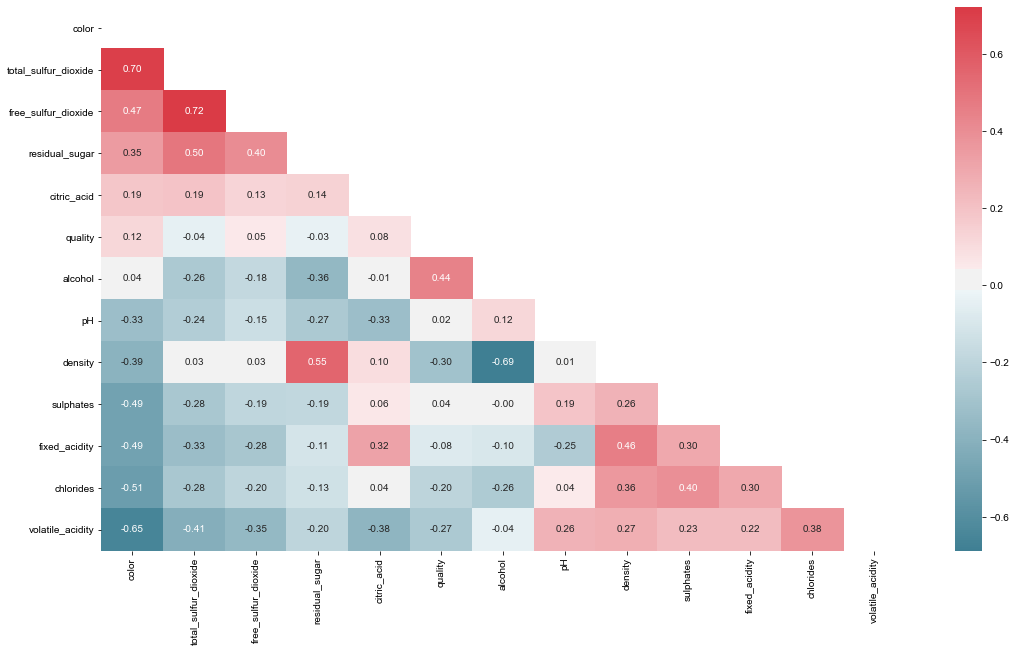

In [24]:
#correlation based on wine types


corr = wines.corr()
top_corr_cols = corr.color.sort_values(ascending=False).keys()
top_corr = corr.loc[top_corr_cols, top_corr_cols]
dropSelf = np.zeros_like(top_corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
plt.figure(figsize=(18, 10))
sns.heatmap(top_corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", mask=dropSelf)
sns.set(font_scale=1.5)
plt.show()
del corr, dropSelf, top_corr



Note:

    Total and free sulfur dioxide have the higest correlations. 
    The residual sugar has a half relation to the total sulfur dioxide and 0.40 with free, it is a good indication that with more residual sugar more sulfur dioxide is added by the winemaker.
    Density has a relatively high positive correlation to residual sugar and relatively high negative correlation to alcohol.
    The chlorides and volatile acidity has -0.51 and -0,65 correlations between color, indicate a tendency to red wines classification.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


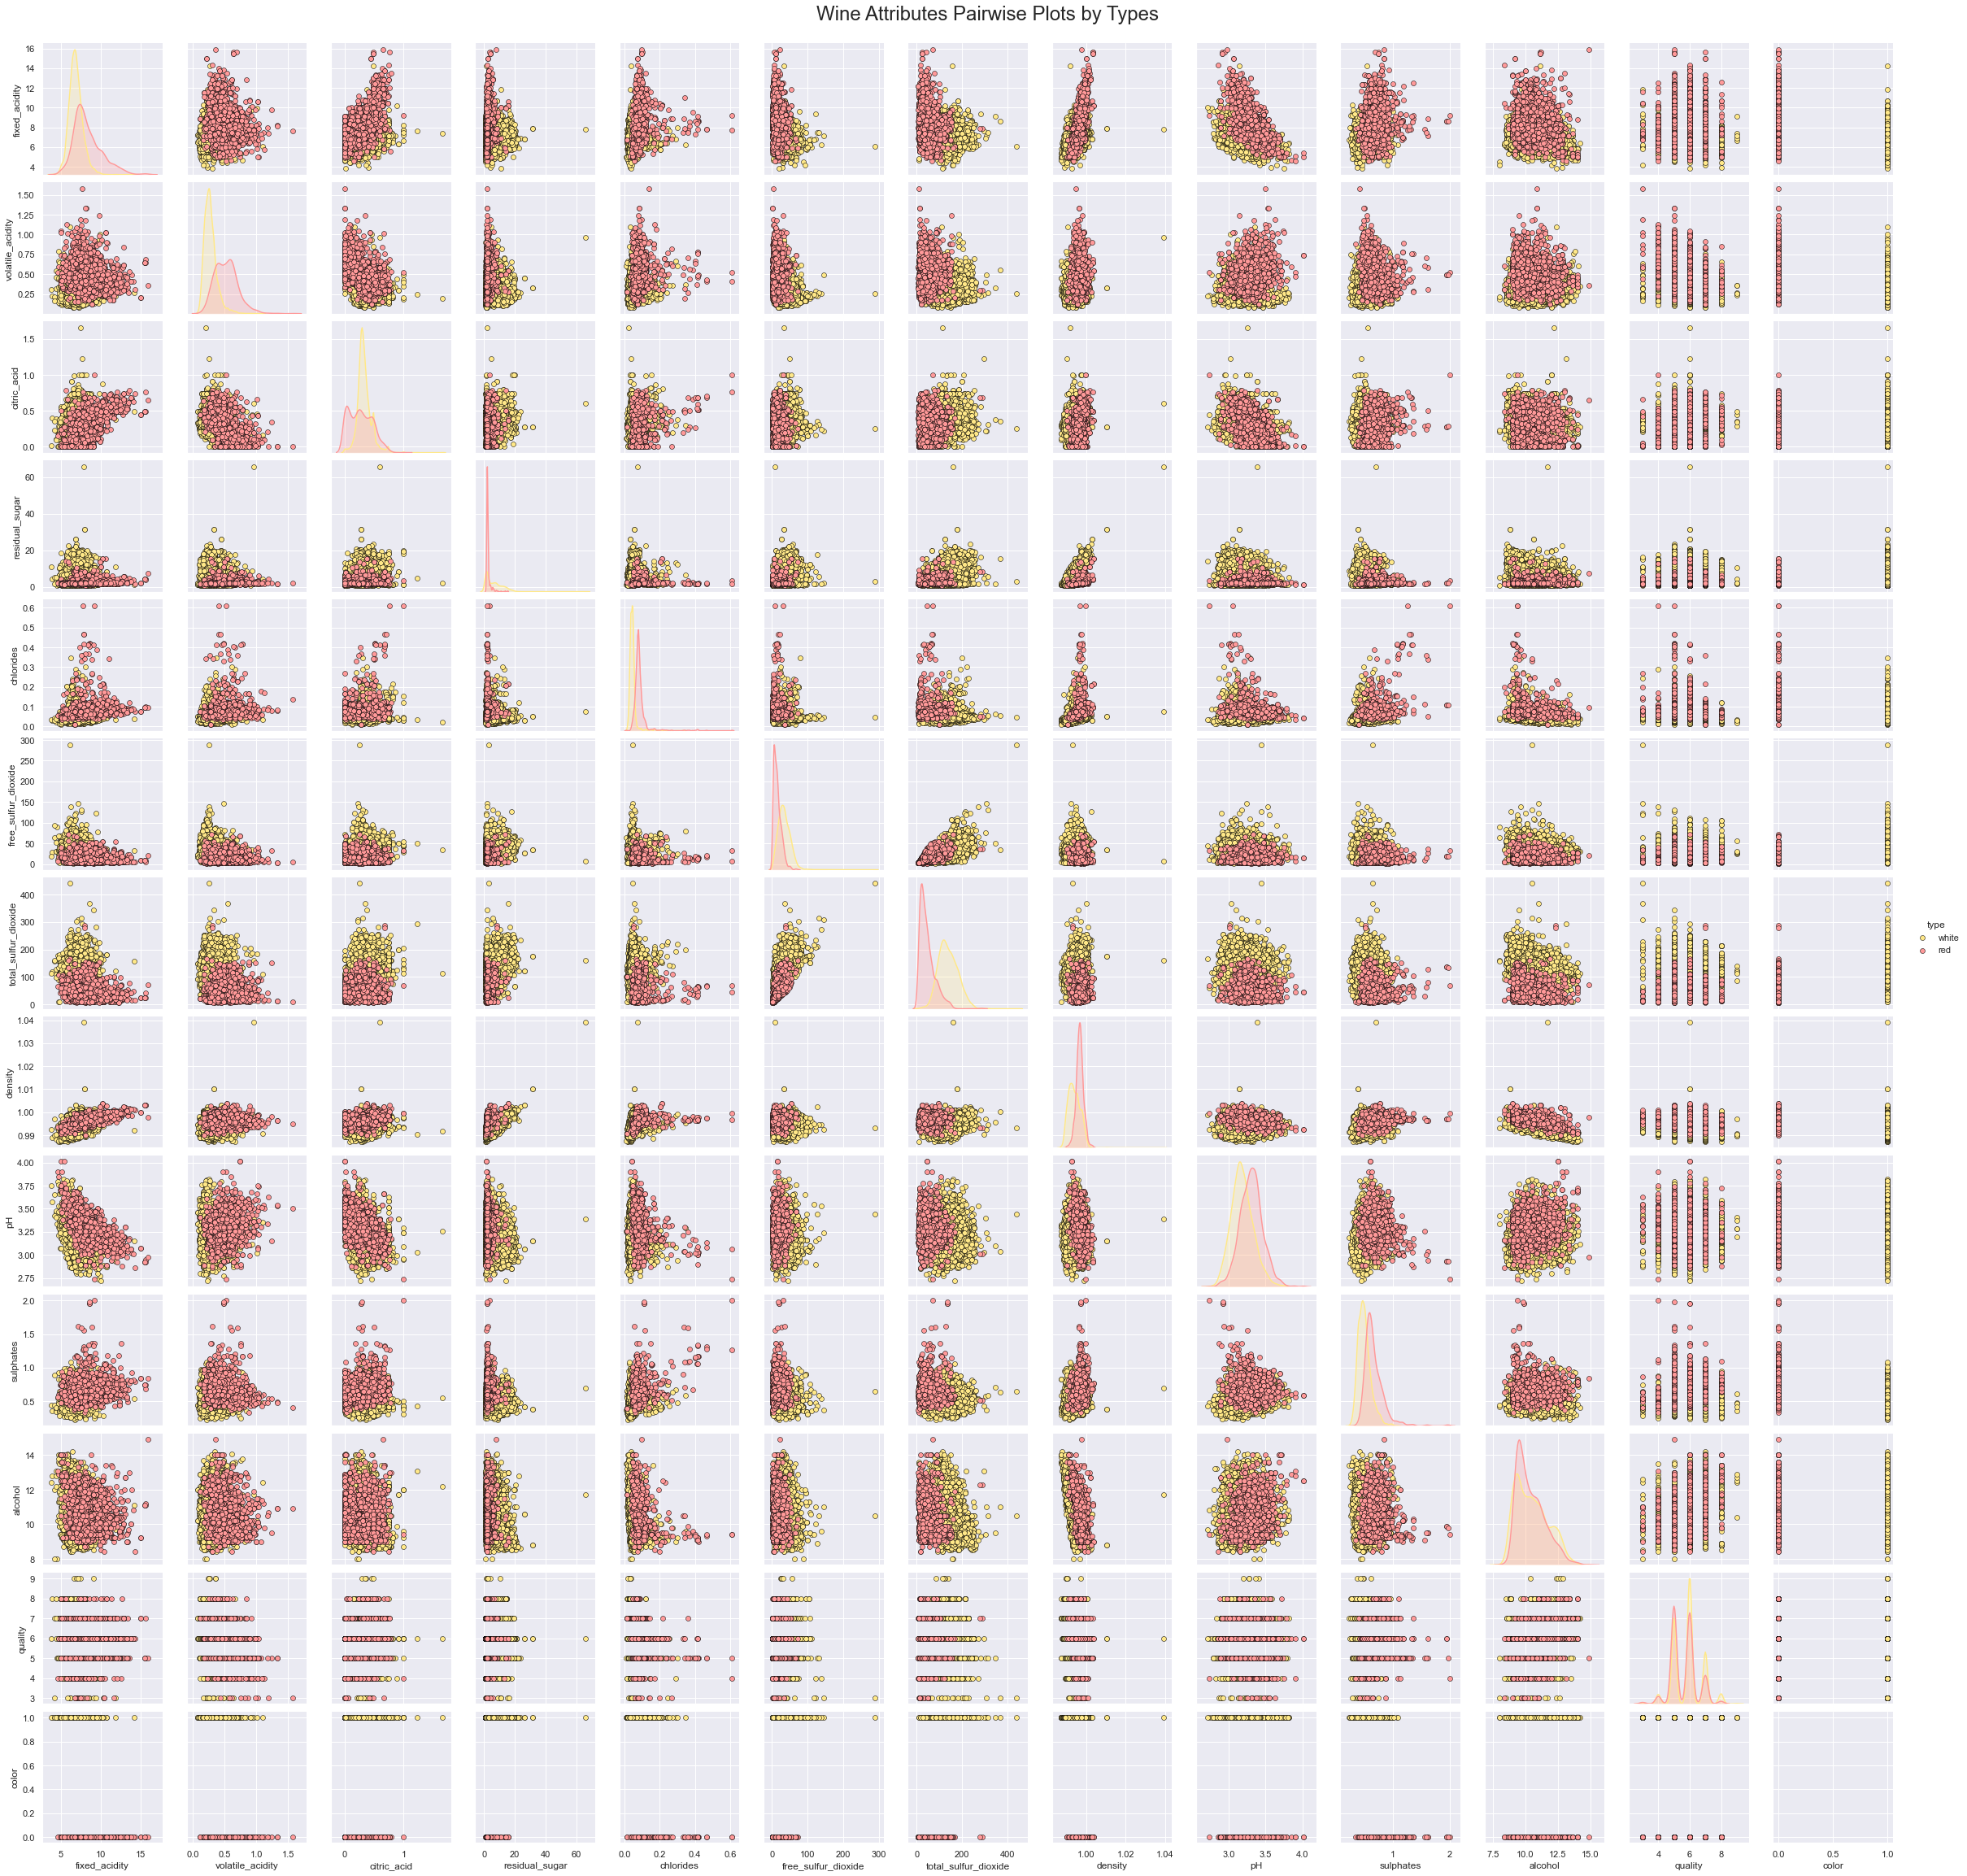

In [26]:
sns.set(font_scale=1.0)
g = sns.pairplot(data = wines, hue='type', palette={'red': '#FF9999', 'white': '#FFE888'},plot_kws=dict(edgecolor='black', linewidth=0.5))
fig = g.fig 
fig.subplots_adjust(top=0.96, wspace=0.2)
t = fig.suptitle('Wine Attributes Pairwise Plots by Types', fontsize=24)



From pair plot above we can notice several interesting patterns, which are in alignment with the insights we obtained earlier at ANOVA test and correlations

    Residual sugar, total sulfur dioxide and citric acid in white wine seems to be much higher than red wine.
    Sulphates, fixed acidity and volatile acidity seem to be higher in red wine as compared to white wine.
    Density has slightly strong negative correlation with alcohol, which is confirmed by the linear trend of the points from left to right in a decreasing (downward) direction.
    Density has slightly strong positive correlation with residual sugar, which is reinforced by two white wine outliers.



Let's see the correlation and pair plots from the perpective of quality:


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


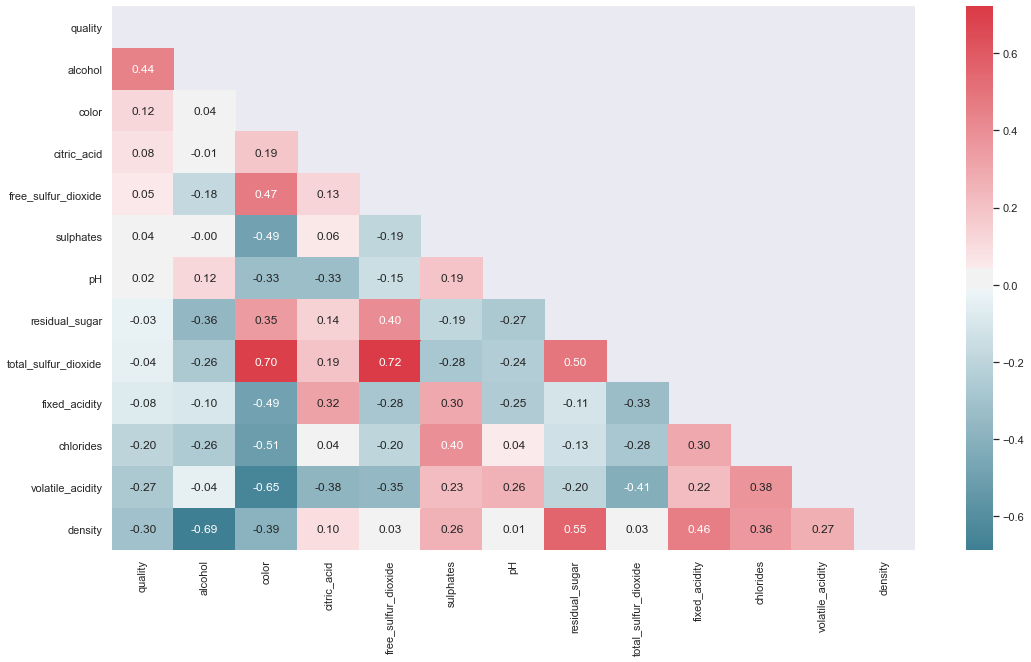

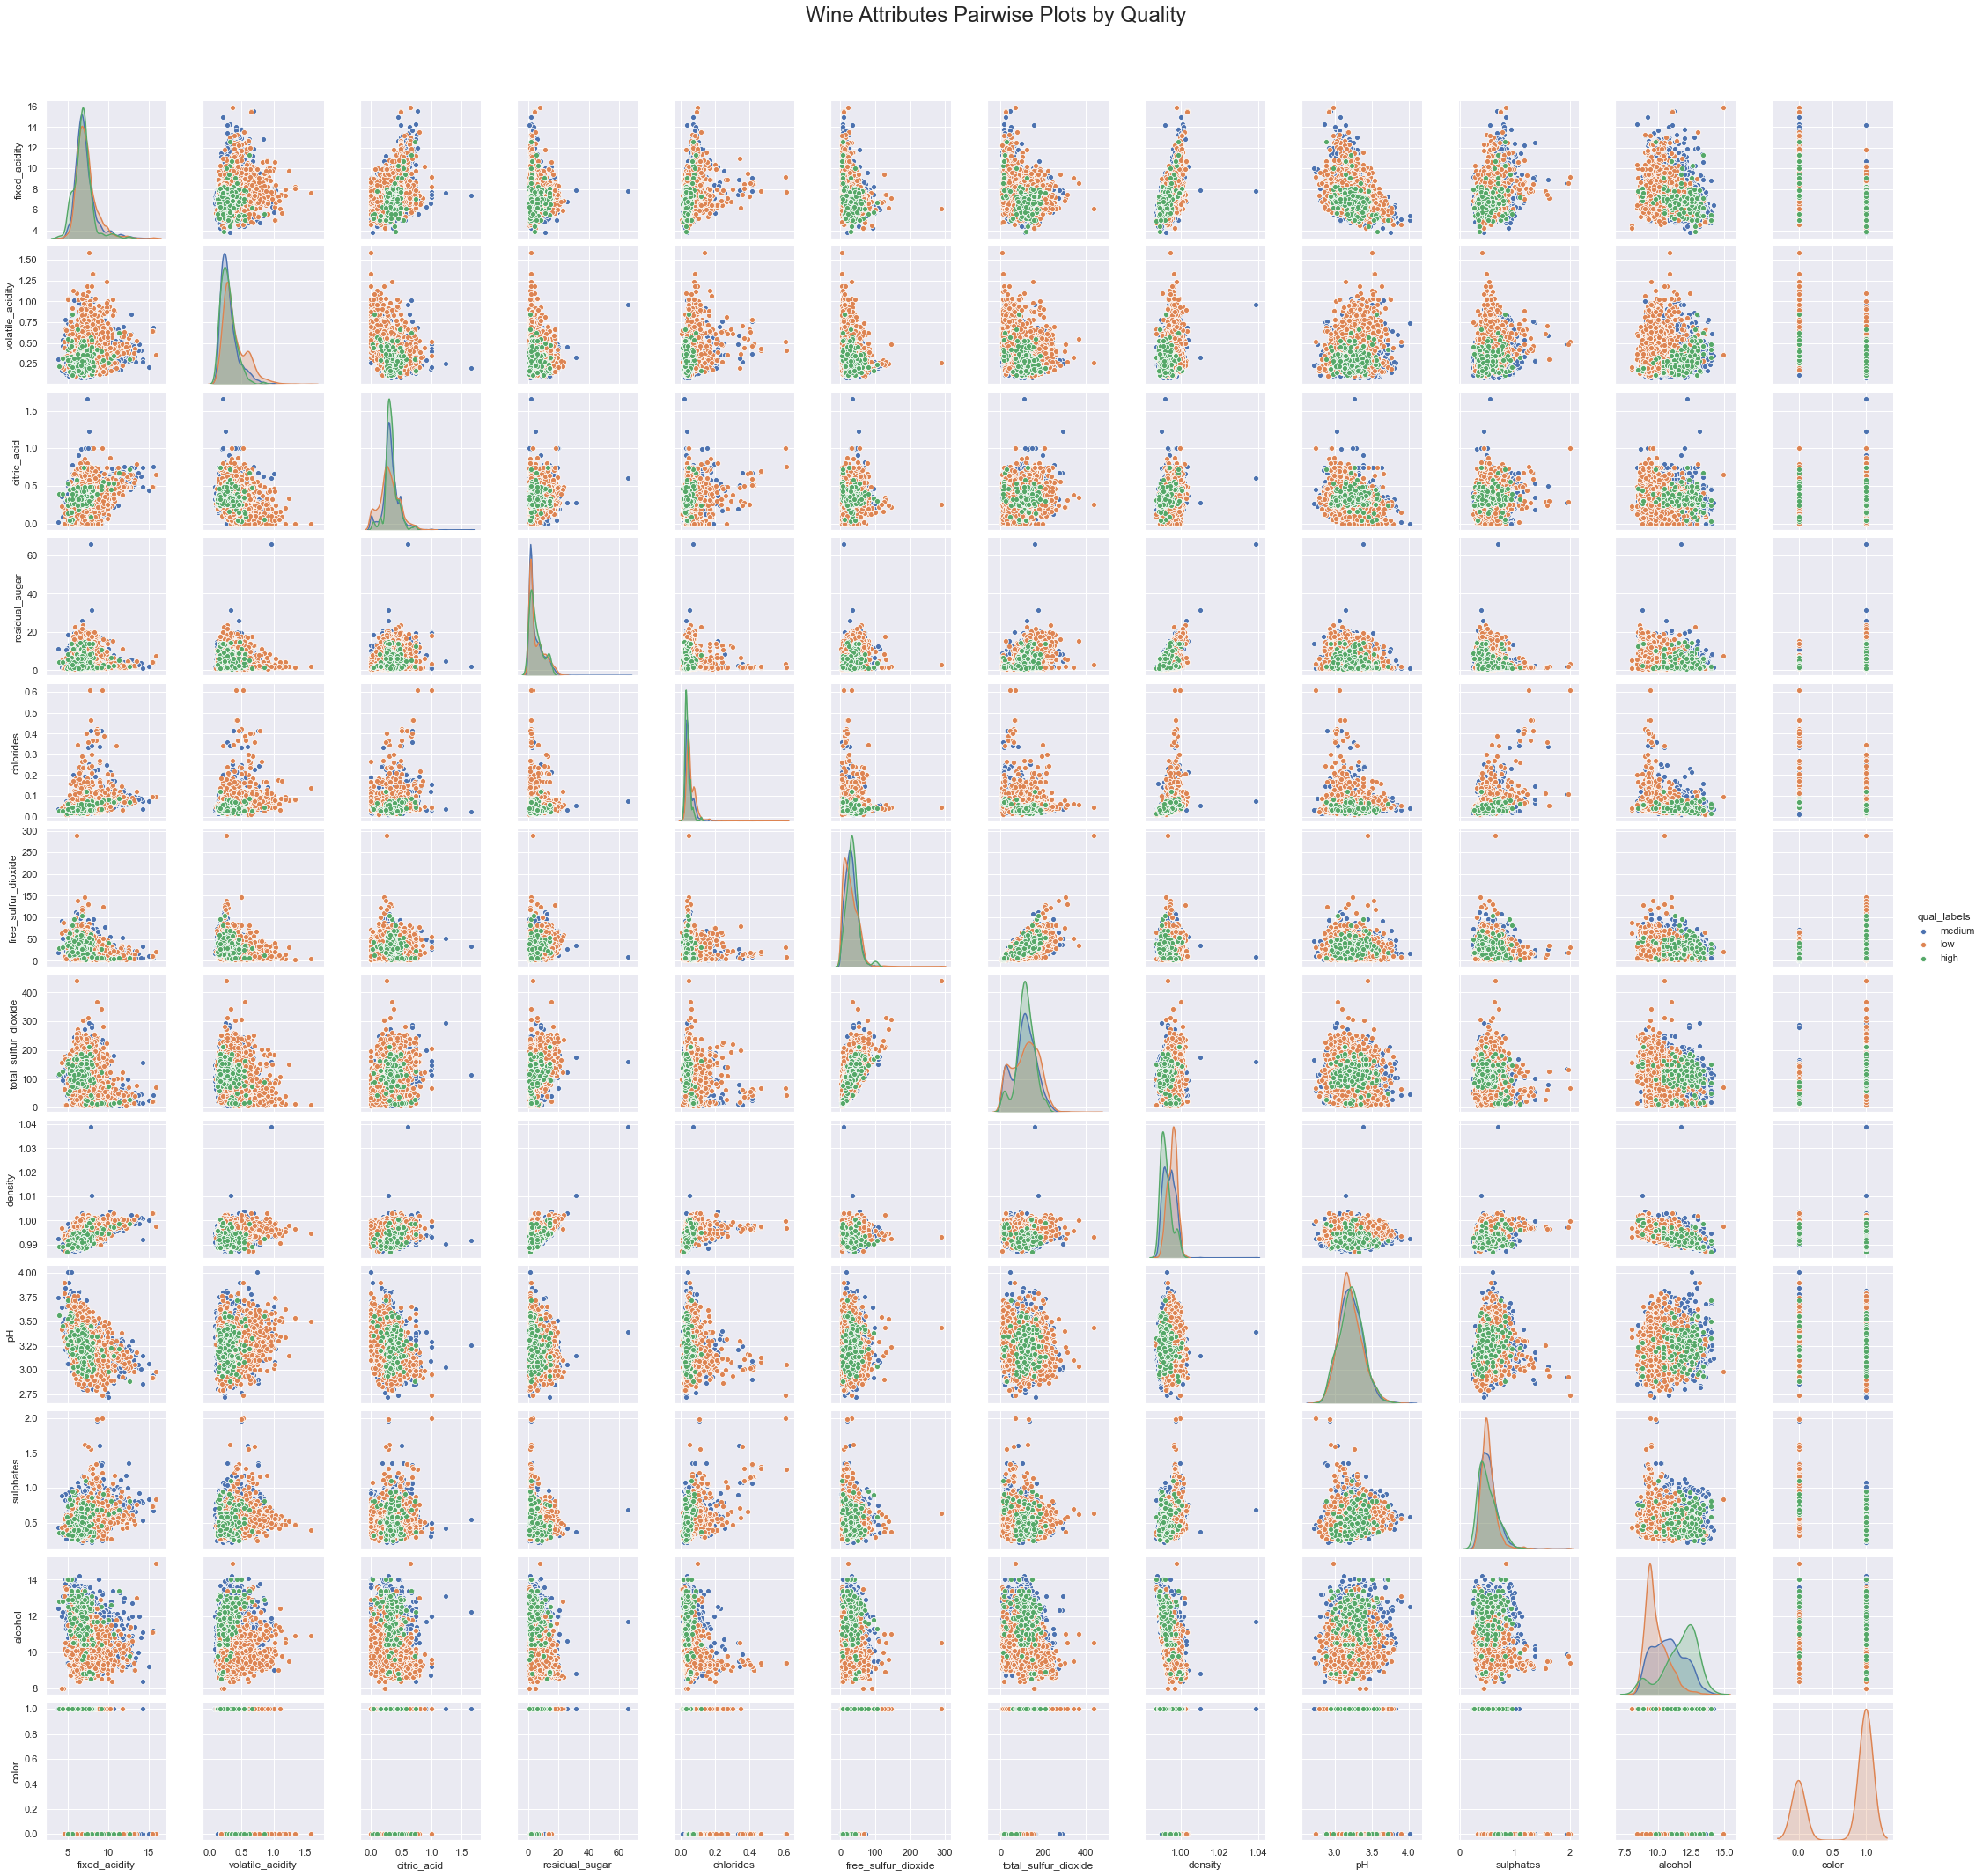

In [27]:
corr = wines.corr()
top_corr_cols = corr.quality.sort_values(ascending=False).keys() 
top_corr = corr.loc[top_corr_cols, top_corr_cols]
dropSelf = np.zeros_like(top_corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
plt.figure(figsize=(18, 10))
sns.heatmap(top_corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", mask=dropSelf)
sns.set(font_scale=1.5)

sns.set(font_scale=1.0)
cols = wines.columns
cols = cols.drop('quality')
g = sns.pairplot(data = wines.loc[:, cols], hue='qual_labels')
fig = g.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Wine Attributes Pairwise Plots by Quality', fontsize=24)

plt.show()

del corr, dropSelf, top_corr, g, fig, t



Again it is in alignment with the insights we obtained earlier at ANOVA test and correlations

    Lower sulphate levels in wines with high quality ratings, but the higest are found in the medium quality
    Lower levels of volatile acids in wines with high quality ratings
    The higest correlation, 0,72, is see between total and free sulfur dioxide, which is expected, but the two measures have low correlation and in opposite directions with the quality,. So, we will treat this if necessary when we check the multicollinearity.

Again it is in alignment with the insights we obtained earlier at ANOVA test and correlations

    Lower sulphate levels in wines with high quality ratings, but the higest are found in the medium quality
    Lower levels of volatile acids in wines with high quality ratings

Let's see the relation of wine quality and their acohol:


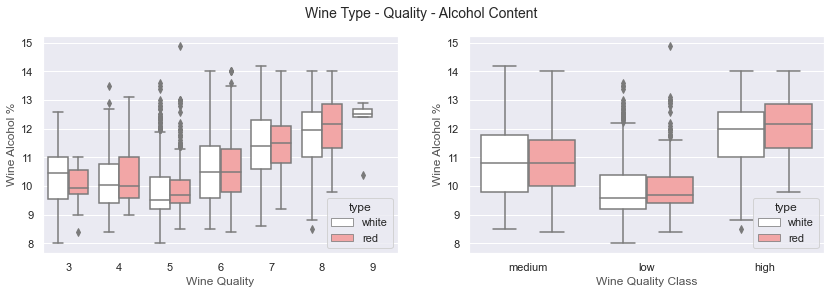

In [28]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
f.suptitle('Wine Type - Quality - Alcohol Content', fontsize=14)

sns.boxplot(x='quality', y='alcohol', hue='type', data=wines, palette={"red": "#FF9999", "white": "white"}, ax=ax1)
ax1.set_xlabel("Wine Quality",size = 12,alpha=0.8)
ax1.set_ylabel("Wine Alcohol %",size = 12,alpha=0.8)

sns.boxplot(x='qual_labels', y='alcohol', hue='type', data=wines, palette={"red": "#FF9999", "white": "white"}, ax=ax2)
ax2.set_xlabel("Wine Quality Class",size = 12,alpha=0.8)
ax2.set_ylabel("Wine Alcohol %",size = 12,alpha=0.8)
plt.show()



Each box plot above depicts the distribution of alcohol level for a particular wine quality rating separated by wine types. We can clearly observe the wine alcohol by volume distribution has an increasing trend based on higher quality rated wine samples, and some outliers in each quality level often depicted by individual points

Let's see visualizing relationships between wine types, quality and acidity:


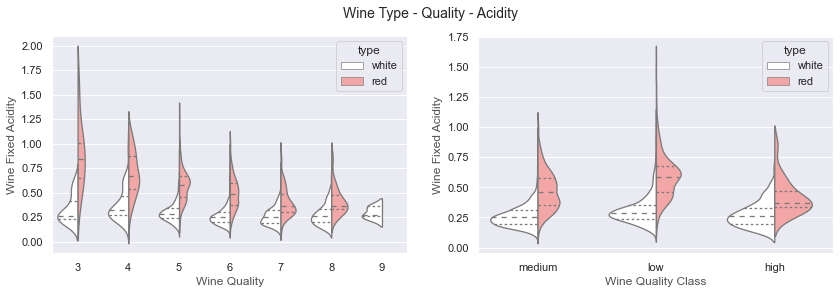

In [29]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
f.suptitle('Wine Type - Quality - Acidity', fontsize=14)

sns.violinplot(x='quality', y='volatile_acidity', hue='type', data=wines, split=True, inner='quart', linewidth=1.3,
               palette={'red': '#FF9999', 'white': 'white'}, ax=ax1)
ax1.set_xlabel("Wine Quality",size = 12,alpha=0.8)
ax1.set_ylabel("Wine Fixed Acidity",size = 12,alpha=0.8)

sns.violinplot(x='qual_labels', y='volatile_acidity', hue='type', data=wines, split=True, inner='quart', linewidth=1.3,
               palette={'red': '#FF9999', 'white': 'white'}, ax=ax2)
ax2.set_xlabel("Wine Quality Class",size = 12,alpha=0.8)
ax2.set_ylabel("Wine Fixed Acidity",size = 12,alpha=0.8)
plt.show()



It is quite evident that red wine samples have higher acidity as compared to its white wine counterparts. Also we can see an overall decrease in acidity with higher quality wine for red wine samples but not so much for white wine samples.

Let's see this obsevation in some 3 variabels graphs analysis:


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2264: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2264: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 720x720 with 0 Axes>

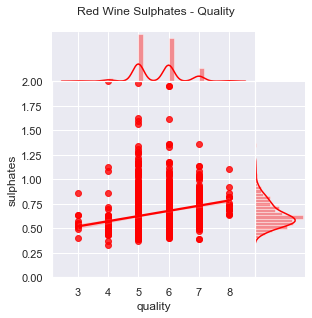

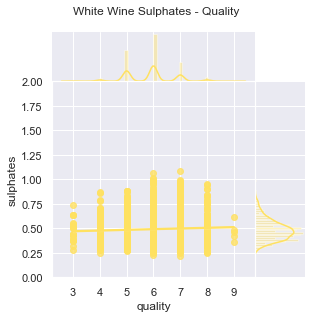

In [30]:
plt.figure(figsize=(10,10))
r = sns.jointplot(x='quality', y='sulphates', data=wines[wines.color == 0], # , ax = ax
                  kind='reg', ylim=(0, 2), color='red', space=0, size=4.5, ratio=4)
r.ax_joint.set_xticks(list(range(3,9)))
rfig = r.fig 
rfig.subplots_adjust(top=0.9)
t = rfig.suptitle('Red Wine Sulphates - Quality', fontsize=12)

w = sns.jointplot(x='quality', y='sulphates', data=wines[wines.color == 1],
                   kind='reg', ylim=(0, 2), color='#FFE160', space=0, size=4.5, ratio=4)
w.ax_joint.set_xticks(list(range(3,10)))
wfig = w.fig 
wfig.subplots_adjust(top=0.9)
t = wfig.suptitle('White Wine Sulphates - Quality', fontsize=12)



While there seems to be some pattern depicting a slight higer sulphate levels for higher quality rated wine samples, the correlation is quite weak. However, we do see this tendecy is caused by higer concentartion on medium quality, and a clearly see that sulphate levels for red wine are much higher as compared to the ones in white wine.

Let's see this observations in some 4 variables graphs analysis:


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


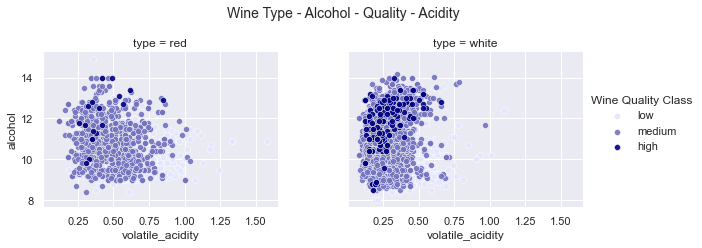

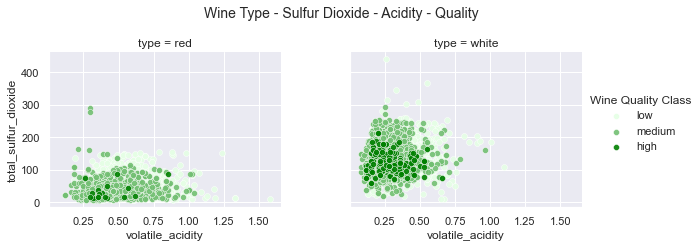

In [31]:
g = sns.FacetGrid(wines, col='type', hue='qual_labels', col_order=['red', 'white'], hue_order=['low', 'medium', 'high'],
                  aspect=1.2, size=3.5, palette=sns.light_palette('navy', 3))
g.map(plt.scatter, 'volatile_acidity', 'alcohol', alpha=0.9, edgecolor='white', linewidth=0.5)
fig = g.fig
fig.subplots_adjust(top=0.8, wspace=0.3)
fig.suptitle('Wine Type - Alcohol - Quality - Acidity', fontsize=14)
l = g.add_legend(title='Wine Quality Class')

g = sns.FacetGrid(wines, col='type', hue='qual_labels', col_order=['red', 'white'], hue_order=['low', 'medium', 'high'],
                  aspect=1.2, size=3.5, palette=sns.light_palette('green', 3))
g.map(plt.scatter, "volatile_acidity", "total_sulfur_dioxide", alpha=0.9, edgecolor='white', linewidth=0.5)
fig = g.fig 
fig.subplots_adjust(top=0.8, wspace=0.3)
fig.suptitle('Wine Type - Sulfur Dioxide - Acidity - Quality', fontsize=14)
l = g.add_legend(title='Wine Quality Class')



From the first pair graphs we can see that hHigher quality wine samples have lower levels of volatile acidity and higher levels of alcohol content as compared to wine samples with medium and low ratings. Besides this, we can also see that volatile acidity levels are slightly lower in white wine samples as compared to red wine samples.

In the second pair graph, the volatile acidity as well as total sulfur dioxide is considerably lower in high quality wine samples. Also, total sulfur dioxide is considerable more in white wine samples as compared to red wine samples. However, volatile acidity levels are slightly lower in white wine samples as compared to red wine samples we also observed in the previous plot.


###### Data Engineering - Cleaning, Transforming, Selection and Reduction

Looks visualize the distribution of the features

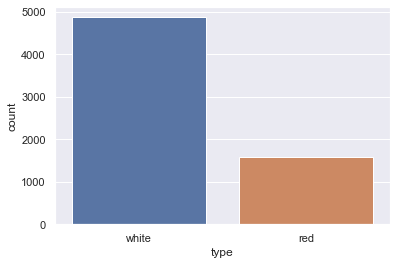

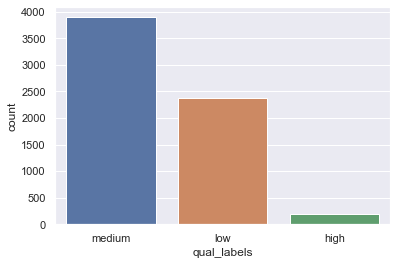

In [32]:
sns.countplot(wines.type)
plt.show()
sns.countplot(wines.qual_labels)
plt.show()

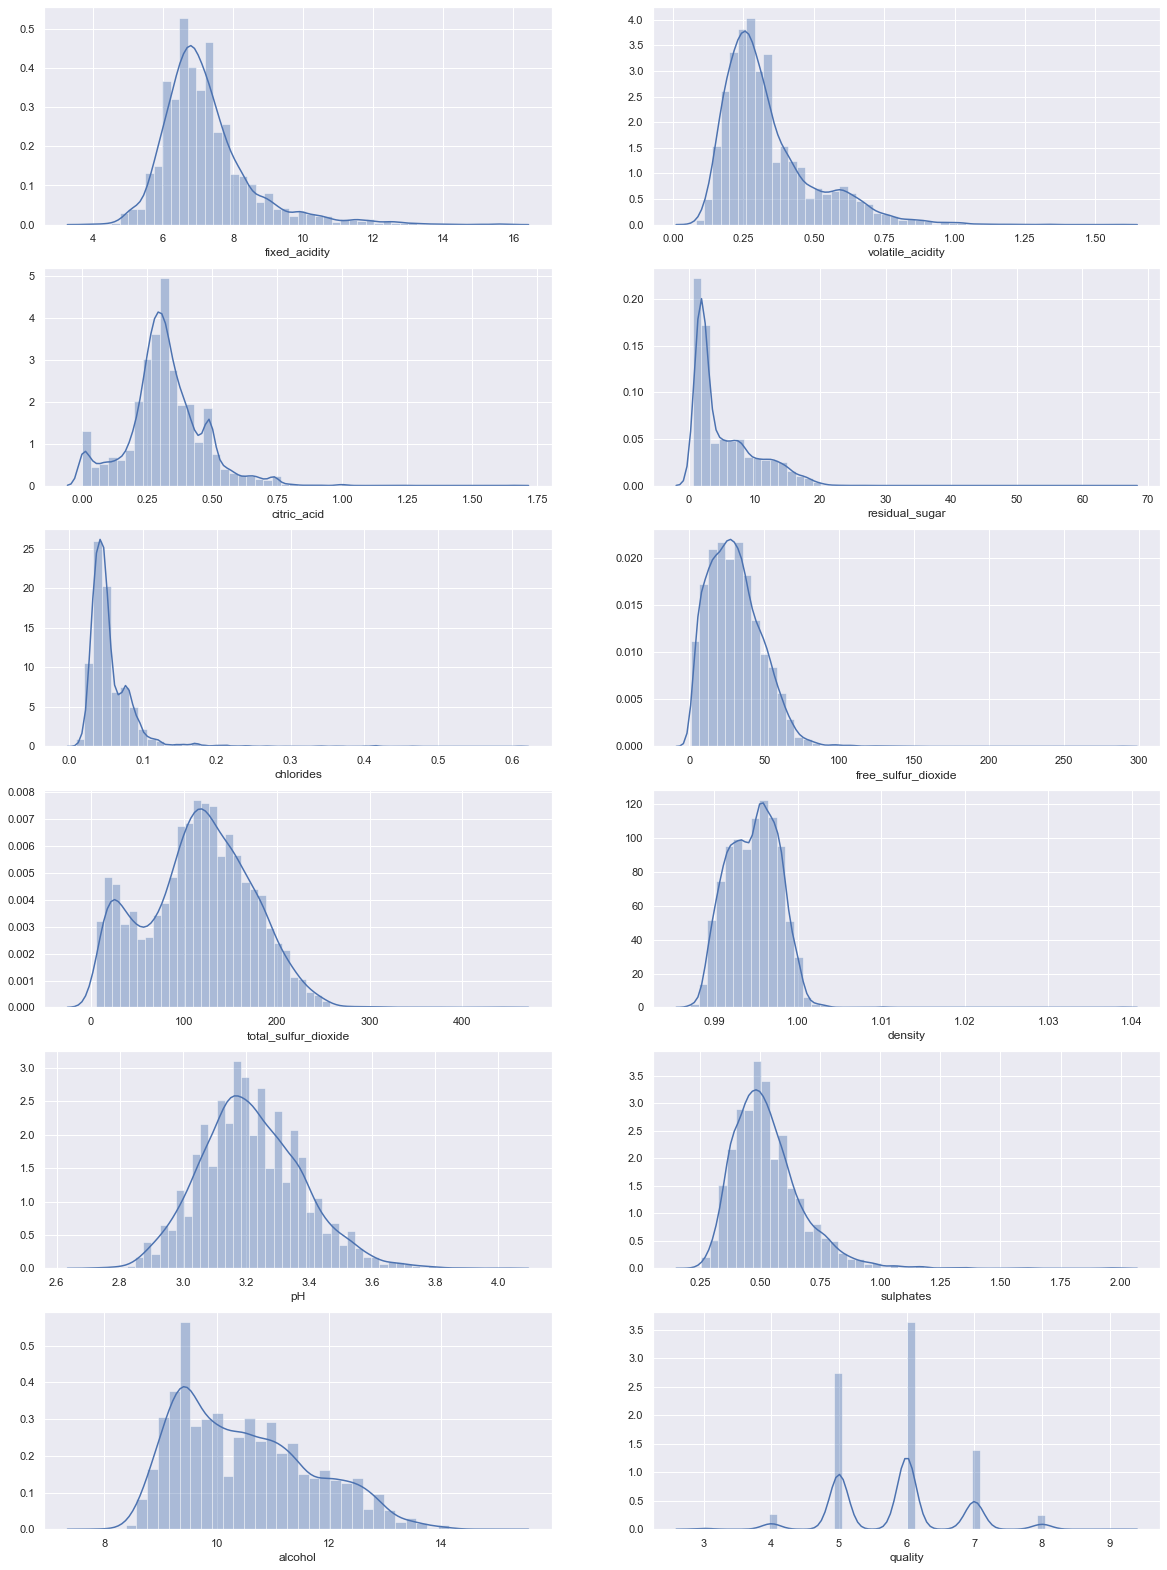

In [33]:
cols=['fixed_acidity', 'volatile_acidity', 'citric_acid',
       'residual_sugar', 'chlorides', 'free_sulfur_dioxide',
       'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'quality']

f, axes = plt.subplots(nrows=6, ncols=2, figsize=(20,28))

for i, var in enumerate(cols):
    row = i//2
    pos = i%2
    
    plot = sns.distplot(wines[var], ax=axes[row][pos])


As we see from the distrtibutions a lot of features are skewed, hence we can apply 2 different techniques - log transform technique and boxcox tranform technique.

###### Box cox transformation of highly skewed features

A Box Cox transformation is a way to transform non-normal data distribution into a normal shape. 

Why does this matter?

1. Model bias and spurious interactions: If you are performing a regression or any statistical modeling, this asymmetrical behavior may lead to a bias in the model. If a factor has a significant effect on the average, because the variability is much larger, many factors will seem to have a stronger effect when the mean is larger. This is not due, however, to a true factor effect but rather to an increased amount of variability that affects all factor effect estimates when the mean gets larger. This will probably generate spurious interactions due to a non-constant variation, resulting in a very complex model with many spurious and unrealistic interactions.
    
2. Normality is an important assumption for many statistical techniques: such as individuals control charts, Cp/Cpk analysis, t-tests and analysis of variance (ANOVA). A substantial departure from normality will bias your capability estimates.

One solution to this is to transform your data into normality using a Box-Cox transformation means that you are able to run a broader number of tests.

At the core of the Box Cox transformation is an exponent, lambda (λ), which varies from -5 to 5. All values of λ are considered and the optimal value for your data is selected; The 'optimal value' is the one which results in the best approximation of a normal distribution curve. The transformation of Y has the form: 

    y(lambda) = {((y**lambda)-1) / lambda if lambda!=0;
                {log y if lambda=0
                
The scipy implementation proceeded with this formula, then you need before take care of negatives values if you have. A common technique for handling negative values is to add a constant value to the data prior to applying the log transform. The transformation is therefore log(Y+a) where a is the constant. Some people like to choose a so that min(Y+a) is a very small positive number (like 0.001). Others choose a so that min(Y+a) = 1. For the latter choice, you can show that a = b – min(Y), where b is either a small number or is 1. This test only works for positive data. However, Box and Cox did propose a second formula that can be used for negative y-values, not implemented in scipy: 

    y(lambda) = {(((y+lambda2)**lambda1)-1 )/lambda1  if lambda1 !=0
                {log (y+lambda2) if lambda1 = 0
                

The formula are deceptively simple. Testing all possible values by hand is unnecessarily labor intensive.

Common Box-Cox Transformations
Lambda value (λ) 	Transformed data (Y')

    -3 	Y**-3 = 1/Y**3
    -2 	Y**-2 = 1/Y**2
    -1 	Y**-1 = 1/Y
    -0.5 	Y**-0.5 = 1/(√(Y))
    0 	log(Y)(*)
    0.5 	Y0.5 = √(Y)
    1 	Y**1 = Y
    2 	Y**2
    3 	Y**3

(*)Note: the transformation for zero is log(0), otherwise all data would transform to Y**0 = 1. The transformation doesn't always work well, so make sure you check your data after the transformation with a normal probability plot or if the skew are reduced, tending to zero.            

In [34]:
numeric_features = list(wines.dtypes[(wines.dtypes != "str") & (wines.dtypes !='object')].index)
numeric_features.remove('color')

skewed_features = wines[numeric_features].apply(lambda x : skew(x.dropna())).sort_values(ascending=False)
skewed_features

chlorides               5.402178
sulphates               1.802523
fixed_acidity           1.721248
volatile_acidity        1.499692
residual_sugar          1.436792
free_sulfur_dioxide     1.223143
alcohol                 0.565304
density                 0.504087
citric_acid             0.474797
pH                      0.391003
quality                 0.189834
total_sulfur_dioxide   -0.000425
dtype: float64

In [35]:
skewness = pd.DataFrame({'skew' : skewed_features})
skewness

skew
chlorides             5.402178
sulphates             1.802523
fixed_acidity         1.721248
volatile_acidity      1.499692
residual_sugar        1.436792
free_sulfur_dioxide   1.223143
alcohol               0.565304
density               0.504087
citric_acid           0.474797
pH                    0.391003
quality               0.189834
total_sulfur_dioxide -0.000425

In [36]:
#Get only highest skewed features
skewness = skewness[abs(skewness) > 0.7]
skewness = skewness.dropna()
print ("There are {} highest skewed numerical features to box cox transform".format(skewness.shape[0]))

There are 6 highest skewed numerical features to box cox transform


In [37]:
l_opt = {}

for feature in skewness.index:
    wines[feature], l_opt[feature] = boxcox((wines[feature]+1))
        
skewed_features2 = wines[skewness.index].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

#compute skewness
skewness2 = pd.DataFrame({'New Skew' : skewed_features2})   
display(pd.concat([skewness, skewness2], axis=1))

skew  New Skew
chlorides            5.402178  0.188541
sulphates            1.802523  0.010381
fixed_acidity        1.721248 -0.062754
volatile_acidity     1.499692  0.113617
residual_sugar       1.436792  0.136151
free_sulfur_dioxide  1.223143 -0.036825

As you can see, we were able at first to bring most the numerical values closer to normal. Maybe you're not satisfied with the results and want to understand if we really need to continue to transform some discrete data. So, let's take a look at the QQ test of these features.

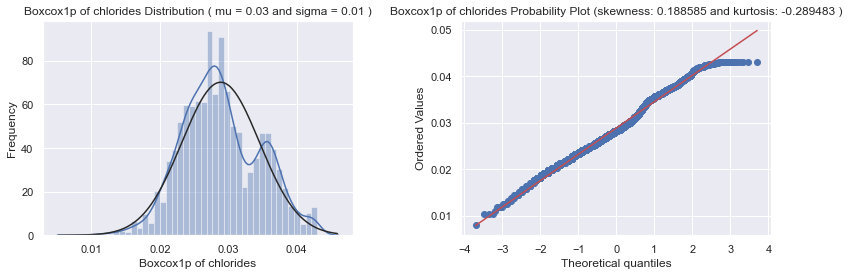

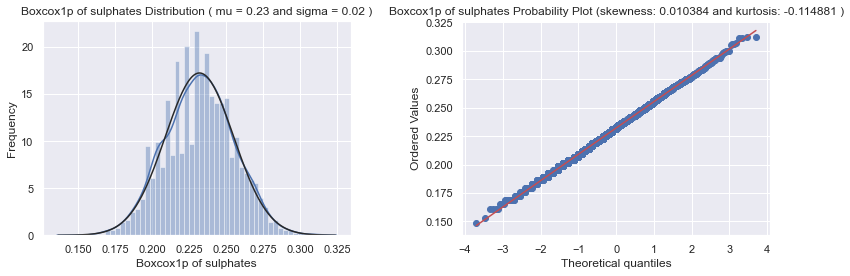

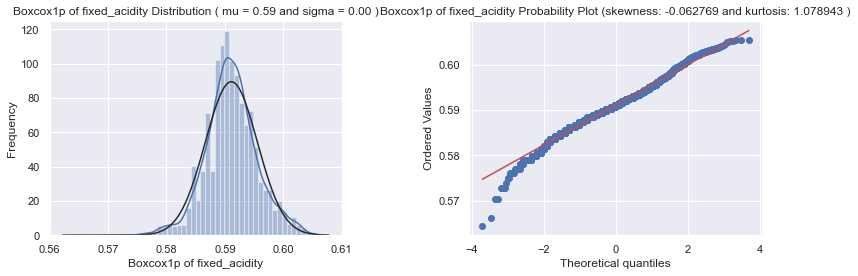

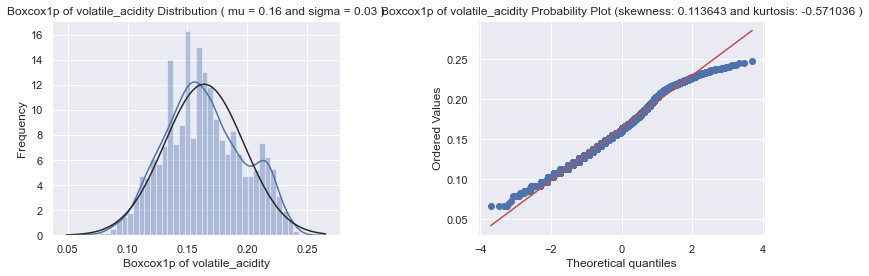

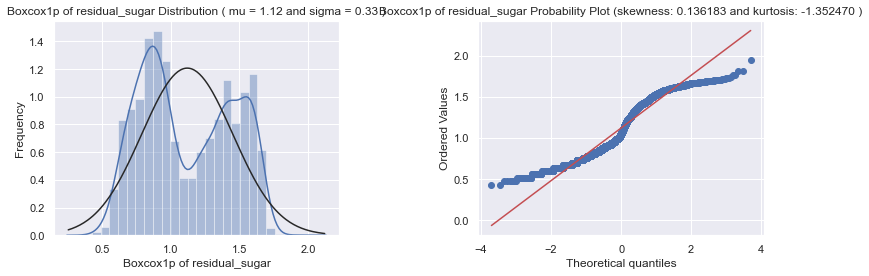

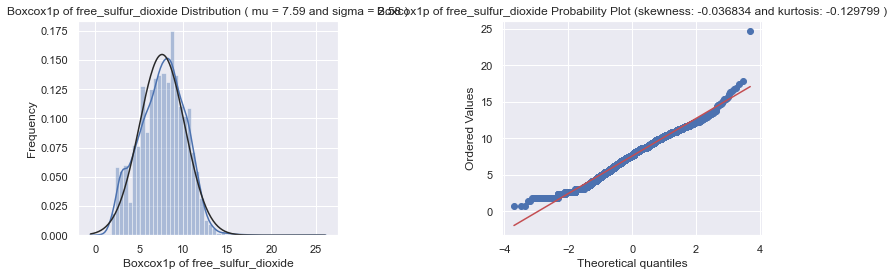

In [38]:
def QQ_plot(data, measure):
    fig = plt.figure(figsize=(12,4))
    
    #get the fitted parameters mu and sigma used by the function
    (mu, sigma) = norm.fit(data)
    
    #Kernel density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)
    fig1.set_title(measure + ' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')
    
    #QQ plot
    fig2 = fig.add_subplot(122)
    res = probplot(data, plot=fig2)
    fig2.set_title(measure + ' Probability Plot (skewness: {:.6f} and kurtosis: {:.6f} )'.\
                   format(data.skew(), data.kurt()), loc='center')

    plt.tight_layout()
    plt.show()
    
for feature in skewness.index:
    QQ_plot(wines[feature], ('Boxcox1p of {}'.format(feature)))
    



As you can see, in addition to having presented significant improvements, they also pass the QQ test and present interesting distributions as we can observe in their respective graphs.

So, we can continue to apply the BoxCox on this features.

###### Identify and treat multicollinearity:

Multicollinearity is the occurrence of high intercorrelations among two or more independent variables in a multiple regression model. Multicollinearity can lead to skewed or misleading results when a researcher or analyst attempts to determine how well each independent variable can be used most effectively to predict or understand the dependent variable in a statistical model. 

One of the most common ways of eliminating the problem of multicollinearity is to first identify collinear independent variables and then remove all but one. It is also possible to eliminate multicollinearity by combining two or more collinear variables into a single variable.

To identify, we need start with the coefficient of determination, r2, is the square of the Pearson correlation coefficient r. The coefficient of determination, with respect to correlation, is the proportion of the variance that is shared by both variables. It gives a measure of the amount of variation that can be explained by the model (the correlation in the model). It is sometimes expressed as a percentage (e.g., 36% instead of 0.36) when we discuss the proportion of variance explained by the correlation. However, you should not write r2 = 36%, or any other percentage. You should write it as a proportion (e.g., r2 = 0.36). 

Already the Variance Inflation Factor (VIF) is a measure of collinearity among predictor variables within a multiple regression. It is may be calculated for each predictor by doing a linear regression of that predictor on all the other predictors, and then obtaining the R2 from that regression. It is calculated by taking the the ratio of the variance of all a given model's betas divide by the variance of a single beta if it were fit alone [1/(1-R2)]. Thus, a VIF of 1.8 tells us that the variance (the square of the standard error) of a particular coefficient is 80% larger than it would be if that predictor was completely uncorrelated with all the other predictors. The VIF has a lower bound of 1 but no upper bound. Authorities differ on how high the VIF has to be to constitute a problem (e.g.: 2.50 (R2 equal to 0.6), sometimes 5 (R2 equal to .8), or greater than 10 (R2 equal to 0.9) and so on).

But there are several situations in which multicollinearity can be safely ignored:

1. Interaction terms and higher-order terms (e.g., squared and cubed predictors) are correlated with main effect terms because they include the main effects terms. Ops! Sometimes we use polynomials to solve problems, indeed! But keep calm, in these cases, standardizing the predictors can remove the multicollinearity.

2. Indicator, like dummy or one-hot-encode, that represent a categorical variable with three or more categories. If the proportion of cases in the reference category is small, the indicator will necessarily have high VIF's, even if the categorical is not associated with other variables in the regression model. But, you need check if some dummy is collinear or has multicollinearity with other features outside of their dummies.

3. Control feature if the feature of interest do not have high VIF's. Here's the thing about multicollinearity: it's only a problem for the features that are collinear. It increases the standard errors of their coefficients, and it may make those coefficients unstable in several ways. But so long as the collinear feature are only used as control feature, and they are not collinear with your feature of interest, there's no problem. The coefficients of the features of interest are not affected, and the performance of the control feature as controls is not impaired.

So, generally, we could run the same model twice, once with severe multicollinearity and once with moderate multicollinearity. This provides a great head-to-head comparison and it reveals the classic effects of multicollinearity. However, when standardizing your predictors doesn't work, you can try other solutions such as:

    removing highly correlated predictors
    linearly combining predictors, such as adding them together
    running entirely different analyses, such as partial least squares regression or principal components analysis

When considering a solution, keep in mind that all remedies have potential drawbacks. If you can live with less precise coefficient estimates, or a model that has a high R-squared but few significant predictors, doing nothing can be the correct decision because it won't impact the fit.

Given the potential for correlation among the predictors, we'll have display the variance inflation factors (VIF), which indicate the extent to which multicollinearity is present in a regression analysis. Hence such variables need to be removed from the model. Deleting one variable at a time and then again checking the VIF for the model is the best way to do this.

So, I start the analysis already having removed the features with he highest collinearities and run VIF.

In [40]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

def VRF(predict, data, y):
   
    scale = StandardScaler(with_std=False)
    df = pd.DataFrame(scale.fit_transform(data), columns= cols)
    features = "+".join(cols)
    df['qual_labels'] = y.values

    # get y and X dataframes based on this regression:
    y, X = dmatrices(predict + ' ~' + features, data = df, return_type='dataframe')

   # Calculate VIF Factors
    # For each X, calculate VIF and save in dataframe
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns

    # Inspect VIF Factors
    display(vif.sort_values('VIF Factor'))
    return vif

cols = wines.columns.str.replace(' ', '_')
df = wines.copy()
df.columns = cols
# Remove the not applied to the qualty classification task
cols = list(cols.drop(['type', 'qual_labels', 'quality']))

vif = VRF('qual_labels', df.loc[:, cols], y_ql)

VIF Factor              features
0     1.000000             Intercept
3     1.456483           citric_acid
10    1.459199             sulphates
2     1.913981      volatile_acidity
9     1.922427                    pH
6     2.496617   free_sulfur_dioxide
5     2.561999             chlorides
1     2.726160         fixed_acidity
11    3.658381               alcohol
4     3.811469        residual_sugar
7     4.279372  total_sulfur_dioxide
12    6.474246                 color
8     9.164542               density



Let's remove the residual suagar and total sulfur dioxide


In [43]:
cols = wines.columns.str.replace(' ', '_')
df = wines.copy()
df.columns = cols
# Remove the higest correlations and run a multiple regression
cols = list(cols.drop(['type', 'qual_labels', 'quality', 'residual_sugar', 'total_sulfur_dioxide']))

vif = VRF('qual_labels', df.loc[:, cols], y_ql)

del df, vif

VIF Factor             features
0     1.000000            Intercept
8     1.402620            sulphates
3     1.433664          citric_acid
5     1.532415  free_sulfur_dioxide
7     1.658454                   pH
2     1.809226     volatile_acidity
1     2.254045        fixed_acidity
4     2.512481            chlorides
9     2.649799              alcohol
6     3.314295              density
10    4.061007                color

###### Feature Selection into the pipeline

Since we have a few features it may be enough only the removal of collinear and multicollinear. However, with collinearity and multicollinearity levels are low and there are models to handle this. Then, it is interesting that we proceed with the selection of variables within the pipeline, allowing us to decide if there will be selection of variables and by which method. We can still improve the results through hyper parameterization and cross-validation. 



PCA

Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. If there are n observations with p variables, then the number of distinct principal components is min(n-1,p). This transformation is defined in such a way that the first principal component has the largest possible variance, and each succeeding component in turn has the highest variance possible under the constraint that it is orthogonal to the preceding components. The resulting vectors are an uncorrelated orthogonal basis set. PCA is sensitive to the relative scaling of the original variables. 

Let's see how PCA can reduce the dimensionality of our dataset with minimum of lose information:

In [48]:
def pca_analysis(df, y_train, feat):
    scale = StandardScaler()
    df = pd.DataFrame(scale.fit_transform(df), index=df.index)
    pca_all = PCA(random_state=101, whiten=True).fit(df)
    
    my_color = y_train
    
    #store the results of PCA into a dataframe
    result=pd.DataFrame(pca_all.transform(df), columns=['PCA%i' % i for i in range(df.shape[1])], index=df.index)
    print(result)
    
    # Plot initialisation
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(result['PCA0'], result['PCA1'], result['PCA2'], c=my_color, cmap="Set2_r", s=60)

    # make simple, bare axis lines through space:
    xAxisLine = ((min(result['PCA0']), max(result['PCA0'])), (0, 0), (0,0))
    ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
    yAxisLine = ((0, 0), (min(result['PCA1']), max(result['PCA1'])), (0,0))
    ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
    zAxisLine = ((0, 0), (0,0), (min(result['PCA2']), max(result['PCA2'])))
    ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')

    # label the axes
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.set_title("PCA on the Wines dataset for " + (feat))
    plt.show()

    X_train , X_test, y, y_test = train_test_split(df , y_train, test_size=0.3, random_state=0)

    KNC = KNeighborsClassifier(algorithm = 'ball_tree', leaf_size = 12, n_neighbors = 12, p  = 1, weights = 'distance')
    KNC = KNC.fit(X_train, y)
    print('KNeighbors Classifier Training Accuracy: {:2.2%}'.format(accuracy_score(y, KNC.predict(X_train))))
    y_pred = KNC.predict(X_test)
    print('KNeighbors Classifier Test Accuracy: {:2.2%}'.format(accuracy_score(y_test, y_pred)))

    print('_' * 40)
    print('\nAccurance on', feat, ' Prediction By Number of PCA COmponents:\n')
    AccPca = pd.DataFrame(columns=['Components', 'Var_ratio', 'Train_Acc', 'Test_Acc'])

    for componets in np.arange(1, df.shape[1]):
        variance_ratio = sum(pca_all.explained_variance_ratio_[:componets])*100
        pca = PCA(n_components=componets, random_state=101, whiten=True)
        X_train_pca = pca.fit_transform(X_train)
        Components = X_train_pca.shape[1]
        KNC = KNeighborsClassifier(algorithm = 'ball_tree', leaf_size = 12, n_neighbors = 12, p  = 1, weights = 'distance')
        KNC = KNC.fit(X_train_pca, y)
        Training_Accuracy = accuracy_score(y, KNC.predict(X_train_pca))
        X_test_pca = pca.transform(X_test)
        y_pred = KNC.predict(X_test_pca)
        Test_Accuracy = accuracy_score(y_test, y_pred)
        AccPca = AccPca.append(pd.DataFrame([(Components, variance_ratio, Training_Accuracy, Test_Accuracy)],
                                            columns=['Components', 'Var_ratio', 'Train_Acc', 'Test_Acc']))#], axis=0)

    AccPca.set_index('Components', inplace=True)
    display(AccPca.sort_values(by='Test_Acc', ascending=False))
    

          PCA0      PCA1      PCA2      PCA3      PCA4      PCA5      PCA6  \
0    -0.212572 -1.458684  0.048624 -1.396338 -1.417801 -1.974360 -0.040000   
1    -0.787229  1.338229 -0.431001  0.706336 -0.333124  0.194453 -0.036206   
2     0.921902 -1.029554  1.308094 -1.695485  0.344633  0.178819 -0.071484   
3    -0.687955 -0.332845  0.037662  1.707495 -1.421629 -1.251514 -0.611733   
4    -0.366152  1.931775 -0.819142 -0.441762 -0.420217  1.435019  0.992593   
...        ...       ...       ...       ...       ...       ...       ...   
6458 -0.382414  1.743266  0.208103 -0.196419  0.477534 -0.022679 -1.143220   
6459  1.180264 -0.850439 -0.519432 -0.479447 -0.128606 -0.195797 -0.190151   
6460 -0.351407  0.260794 -0.539977 -0.504008 -0.363160 -1.417535  0.331409   
6461 -1.483626 -1.698396  0.566723  1.159257  3.403621 -0.437496  0.049393   
6462  1.180264 -0.850439 -0.519432 -0.479447 -0.128606 -0.195797 -0.190151   

          PCA7      PCA8      PCA9     PCA10     PCA11  
0    -

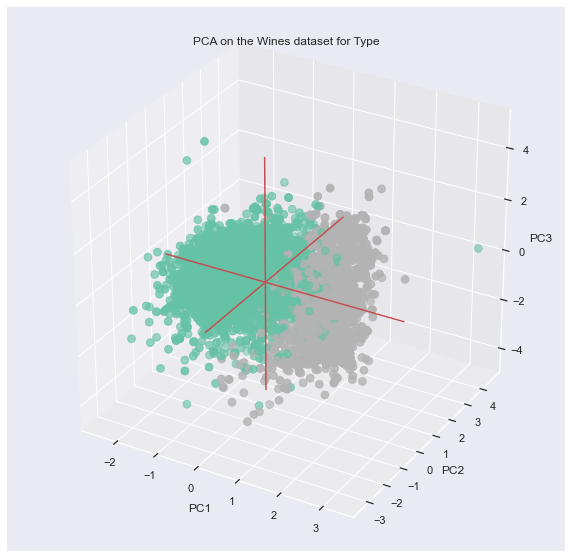

KNeighbors Classifier Training Accuracy: 99.98%
KNeighbors Classifier Test Accuracy: 99.33%
________________________________________

Accurance on Type  Prediction By Number of PCA COmponents:



Var_ratio  Train_Acc  Test_Acc
Components                                
11          99.427453   0.999779  0.993811
10          97.667786   0.999779  0.993296
8           91.839268   0.999779  0.991748
9           95.160591   0.999779  0.990717
6           82.997327   0.999779  0.989170
7           87.723789   0.999779  0.989170
4           70.692560   0.999779  0.988138
5           77.709477   0.999779  0.987622
3           61.525143   0.999779  0.985560
2           48.484340   0.999779  0.981434
1           26.145038   0.999779  0.973182

In [49]:
cols = wines.columns
cols = list(cols.drop(['type', 'qual_labels', 'color']))
pca_analysis(wines.loc[:, cols], y_tp, 'Type')

          PCA0      PCA1      PCA2      PCA3      PCA4      PCA5      PCA6  \
0    -0.056393 -1.327778 -0.101243  1.738254 -1.525479  1.591053 -1.332577   
1    -0.980974  1.042241 -0.290435 -0.395279 -0.337367 -0.344885  0.203156   
2     1.389859 -0.564231  0.929591  1.339225  1.021824  0.106792  0.141876   
3    -0.733428 -0.668484  0.513815 -0.618690 -2.119690  0.326856 -0.472111   
4    -0.703198  1.745264 -0.903357  0.601409  0.610565 -0.861116  1.520796   
...        ...       ...       ...       ...       ...       ...       ...   
6458 -0.614416  1.759881 -0.023968 -0.328829 -0.192558 -0.604537 -0.239974   
6459  1.461074 -0.611807 -0.621129  0.291380 -0.279946 -0.077004  0.531559   
6460 -0.433545  0.212230 -0.635302  0.425753 -0.768625  1.248691  0.184722   
6461 -0.950265 -1.674691  0.522739 -2.876681  1.536946  0.541936  1.177497   
6462  1.461074 -0.611807 -0.621129  0.291380 -0.279946 -0.077004  0.531559   

          PCA7      PCA8      PCA9     PCA10     PCA11  
0     

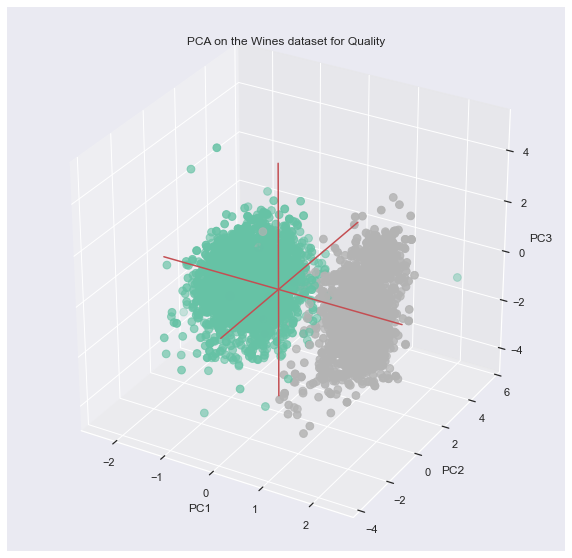

KNeighbors Classifier Training Accuracy: 100.00%
KNeighbors Classifier Test Accuracy: 99.90%
________________________________________

Accurance on Quality  Prediction By Number of PCA COmponents:



Var_ratio  Train_Acc  Test_Acc
Components                                
11          99.485315        1.0  0.998453
10          98.577969        1.0  0.997937
6           85.704486        1.0  0.997421
9           96.547242        1.0  0.997421
5           80.594934        1.0  0.996906
8           93.557958        1.0  0.996906
2           53.928887        1.0  0.995874
7           90.053091        1.0  0.995874
3           66.550688        1.0  0.994843
4           74.622660        1.0  0.994843
1           32.494973        1.0  0.993811

In [50]:
cols = wines.columns
cols = list(cols.drop(['type', 'qual_labels', 'quality']))
pca_analysis(wines.loc[:, cols], y_tp, 'Quality')

###### Linear Discriminant Analysis (LDA)

As a supervised dimensionality reduction technique for maximizing class separability. LDA can be used as a technique for feature extraction to increase the computational efficiency and reduce the degree of over-fitting due to the curse of dimensionality in nonregularized models.

So, the goal is to find the feature subspace that optimizes class separability.

However, even if one or more of those assumptions are slightly violated, LDA for dimensionality reduction can still work reasonably well.

Some Important Parameters: solver : string, optional Solver to use, possible values:

  - svd: Singular value decomposition (default).
    Does not compute the covariance matrix, therefore this solver is
    recommended for data with a large number of features.
  - eigen: Eigenvalue decomposition, can be combined with shrinkage.

shrinkage : string or float, optional Shrinkage parameter, possible values:

  - None: no shrinkage (default).
  - auto: automatic shrinkage using the Ledoit-Wolf lemma.
  - float between 0 and 1: fixed shrinkage parameter.

Note that shrinkage works only with 'lsqr' and 'eigen' solvers.

###### Modeling

###### Logistic Regression

Since it is a binary classification task, we try first with a simple logistic regression.

This class implements regularized logistic regression using the 'liblinear' library, 'newton-cg', 'sag' and 'lbfgs' solvers. It can handle both dense and sparse input.

Main Parameters

    class_weight : dict or 'balanced', default: None The "balanced" mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).

    For how class_weight works: It penalizes mistakes in samples of class[i] with class_weight[i] instead of 1. So higher class-weight means you want to put more emphasis on a class. For example, our class 0 is 1.24 times more frequent than class 1. So you should increase the class_weight of class 1 relative to class 0, say {1: 0.6, 0: 0.4}. If the class_weight doesn't sum to 1, it will basically change the regularization parameter.

    "balanced" basically means replicating the smaller class until you have as many samples as in the larger one, but in an implicit way.

    warm_start : bool, default: False. Useless for liblinear solver.
    'clf__multi_class' : ['ovr', 'multinomial'] for 'clf__solver': ['newton-cg', 'sag', 'lbfgs']

Attributes:

    coef_ : array, shape (1, n_features) or (n_classes, n_features)
    intercept_ : array, shape (1,) or (n_classes,)
    niter : array, shape (n_classes,) or (1, )


###### predicting color of the wine

In [79]:
wines.type = wines.type.map({'white':0, 'red':1})

In [80]:
wines.head(2)

type  fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
0     0       0.584918          0.117102         0.36        0.700579   
1     0       0.589343          0.148483         0.36        1.428227   

   chlorides  free_sulfur_dioxide  total_sulfur_dioxide  density    pH  \
0   0.024114             4.476099                  70.0  0.99202  3.43   
1   0.027558            10.837131                 180.0  0.99580  3.08   

   sulphates  alcohol  quality qual_labels  color  
0   0.258088     10.4        7      medium      1  
1   0.213864      9.2        5         low      1

In [91]:
X = wines[['type','fixed_acidity','volatile_acidity','citric_acid','residual_sugar','chlorides',
           'free_sulfur_dioxide','total_sulfur_dioxide','density','pH','sulphates','alcohol']]

y = wines['color']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=40)

In [92]:
X_train_scaled = StandardScaler().fit_transform(X_train)
X_test_scaled = StandardScaler().fit_transform(X_test)

In [93]:
lr = LogisticRegression(random_state=40)
lr.fit(X_train_scaled, y_train)

LogisticRegression(random_state=40)

In [94]:
train_accuracy = lr.score(X_train_scaled, y_train)
test_accuracy = lr.score(X_test_scaled, y_test)
print('One-vs-rest', '-'*35, 
      'Accuracy in Train Group   : {:.2f}'.format(train_accuracy), 
      'Accuracy in Test  Group   : {:.2f}'.format(test_accuracy), sep='\n')

One-vs-rest
-----------------------------------
Accuracy in Train Group   : 1.00
Accuracy in Test  Group   : 1.00


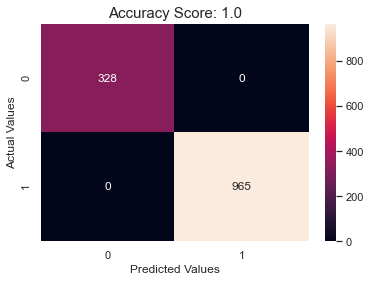

In [97]:
from sklearn.metrics import confusion_matrix as cm

predictions = lr.predict(X_test_scaled)
score = round(accuracy_score(y_test, predictions), 3)
cm1 = cm(y_test, predictions)
sns.heatmap(cm1, annot=True, fmt=".0f")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Accuracy Score: {0}'.format(score), size = 15)
plt.show()



In [100]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       328
           1       1.00      1.00      1.00       965

    accuracy                           1.00      1293
   macro avg       1.00      1.00      1.00      1293
weighted avg       1.00      1.00      1.00      1293



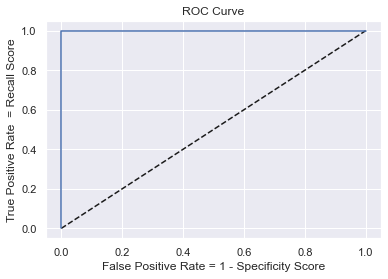

In [101]:
#probs = lr.predict_proba(X_test_scaled)[:,1] 
fpr, tpr, thresholds  = roc_curve(y_test, predictions)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate = 1 - Specificity Score')
plt.ylabel('True Positive Rate  = Recall Score')
plt.title('ROC Curve')
plt.show()

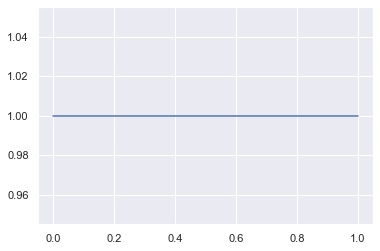

In [103]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_test, predictions)

plt.plot(recall, precision)
plt.show()

###### predicting quality of the wine

In [108]:
wines['qual_labels'].unique()

array(['medium', 'low', 'high'], dtype=object)

In [109]:
wines.qual_labels = wines.qual_labels.map({'low':0, 'medium':1, 'high':2})

In [110]:
wines.head(2)

type  fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
0     0       0.584918          0.117102         0.36        0.700579   
1     0       0.589343          0.148483         0.36        1.428227   

   chlorides  free_sulfur_dioxide  total_sulfur_dioxide  density    pH  \
0   0.024114             4.476099                  70.0  0.99202  3.43   
1   0.027558            10.837131                 180.0  0.99580  3.08   

   sulphates  alcohol  quality  qual_labels  color  
0   0.258088     10.4        7            1      1  
1   0.213864      9.2        5            0      1

In [121]:
X = wines[['fixed_acidity','volatile_acidity','citric_acid','residual_sugar','chlorides',
           'free_sulfur_dioxide','total_sulfur_dioxide','density','pH','sulphates','alcohol']]

y = wines['qual_labels']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=40)

X_train_scaled = StandardScaler().fit_transform(X_train)
X_test_scaled = StandardScaler().fit_transform(X_test)

lr = LogisticRegression(random_state=40)
lr.fit(X_train_scaled, y_train)

train_accuracy = lr.score(X_train_scaled, y_train)
test_accuracy = lr.score(X_test_scaled, y_test)
print('One-vs-rest', '-'*35, 
      'Accuracy in Train Group   : {:.2f}'.format(train_accuracy), 
      'Accuracy in Test  Group   : {:.2f}'.format(test_accuracy), sep='\n')



One-vs-rest
-----------------------------------
Accuracy in Train Group   : 0.72
Accuracy in Test  Group   : 0.71


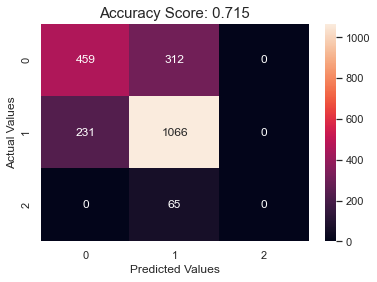

In [122]:
predictions = lr.predict(X_test_scaled)
score = round(accuracy_score(y_test, predictions), 3)
cm1 = cm(y_test, predictions)
sns.heatmap(cm1, annot=True, fmt=".0f")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Accuracy Score: {0}'.format(score), size = 15)
plt.show()


In [123]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.67      0.60      0.63       771
           1       0.74      0.82      0.78      1297
           2       0.00      0.00      0.00        65

    accuracy                           0.71      2133
   macro avg       0.47      0.47      0.47      2133
weighted avg       0.69      0.71      0.70      2133



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


As we see logistic regression is good at predicting binary classes of colors but not three classes of quality range from 'low', 'medium', 'high'

###### K-Nearest neighbors

One-vs-rest
-----------------------------------
Accuracy in Train Group   : 0.81
Accuracy in Test  Group   : 0.72


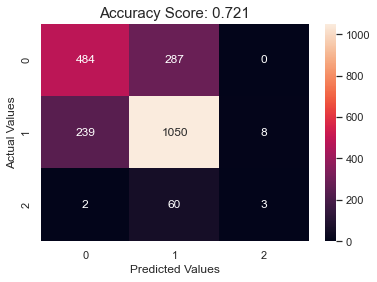

              precision    recall  f1-score   support

           0       0.67      0.63      0.65       771
           1       0.75      0.81      0.78      1297
           2       0.27      0.05      0.08        65

    accuracy                           0.72      2133
   macro avg       0.56      0.49      0.50      2133
weighted avg       0.71      0.72      0.71      2133



In [126]:
X = wines[['fixed_acidity','volatile_acidity','citric_acid','residual_sugar','chlorides',
           'free_sulfur_dioxide','total_sulfur_dioxide','density','pH','sulphates','alcohol']]

y = wines['qual_labels']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=40)

X_train_scaled = StandardScaler().fit_transform(X_train)
X_test_scaled = StandardScaler().fit_transform(X_test)

knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)

train_accuracy = knn.score(X_train_scaled, y_train)
test_accuracy = knn.score(X_test_scaled, y_test)
print('One-vs-rest', '-'*35, 
      'Accuracy in Train Group   : {:.2f}'.format(train_accuracy), 
      'Accuracy in Test  Group   : {:.2f}'.format(test_accuracy), sep='\n')

predictions = knn.predict(X_test_scaled)
score = round(accuracy_score(y_test, predictions), 3)
cm1 = cm(y_test, predictions)
sns.heatmap(cm1, annot=True, fmt=".0f")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Accuracy Score: {0}'.format(score), size = 15)
plt.show()

print(classification_report(y_test, predictions))

###### Random Forest Classifier

One-vs-rest
-----------------------------------
Accuracy in Train Group   : 1.00
Accuracy in Test  Group   : 0.79


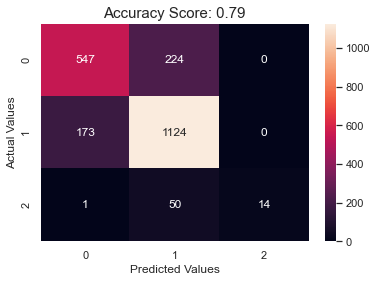

              precision    recall  f1-score   support

           0       0.76      0.71      0.73       771
           1       0.80      0.87      0.83      1297
           2       1.00      0.22      0.35        65

    accuracy                           0.79      2133
   macro avg       0.85      0.60      0.64      2133
weighted avg       0.79      0.79      0.78      2133



In [127]:
X = wines[['fixed_acidity','volatile_acidity','citric_acid','residual_sugar','chlorides',
           'free_sulfur_dioxide','total_sulfur_dioxide','density','pH','sulphates','alcohol']]

y = wines['qual_labels']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=40)

X_train_scaled = StandardScaler().fit_transform(X_train)
X_test_scaled = StandardScaler().fit_transform(X_test)

RFC = RandomForestClassifier()
RFC.fit(X_train_scaled, y_train)

train_accuracy = RFC.score(X_train_scaled, y_train)
test_accuracy = RFC.score(X_test_scaled, y_test)
print('One-vs-rest', '-'*35, 
      'Accuracy in Train Group   : {:.2f}'.format(train_accuracy), 
      'Accuracy in Test  Group   : {:.2f}'.format(test_accuracy), sep='\n')

predictions = RFC.predict(X_test_scaled)
score = round(accuracy_score(y_test, predictions), 3)
cm1 = cm(y_test, predictions)
sns.heatmap(cm1, annot=True, fmt=".0f")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Accuracy Score: {0}'.format(score), size = 15)
plt.show()

print(classification_report(y_test, predictions))

###### XGBoost (eXtreme Gradient Boosting)


XGBoost (eXtreme Gradient Boosting)

XGBoost is an advanced implementation of gradient boosting algorithm. It's a highly sophisticated algorithm, powerful enough to deal with all sorts of irregularities of data.

1. Standard GBM implementation has no regularization like XGBoost, therefore it also helps to reduce overfitting.
2. XGBoost implements parallel processing to making a tree using all cores and is blazingly faster as compared to GBM.
3. XGBoost also supports implementation on Hadoop.
4. High flexibility, it allow users to define custom optimization objectives and evaluation criteria.
5. XGBoost has an in-built routine to handle missing values.
6. It make splits up to the max_depth specified and then start pruning the tree backwards and remove splits beyond which there is no positive gain.
7. Sometimes a split of negative loss say -2 may be followed by a split of positive loss +10. GBM would stop as it encounters -2. But XGBoost will go deeper and it will see a combined effect of +8 of the split and keep both.
8. XGBoost allows user to run a cross-validation at each iteration of the boosting process and thus it is easy to get the exact optimum number of boosting iterations in a single run. You don't need use grid search.
9. User can start training an XGBoost model from its last iteration of previous run.

The overall parameters have been divided into 3 categories by XGBoost authors, let's see the most importants:

1. General Parameters: Guide the overall functioning:
        
        booster: default is gbtree fom ['gbtree', 'gblinear']

2. Booster Parameters: Guide the individual booster (tree/regression) at each step:
        
      1. learning_rate (eta): default is 0.3. Makes the model more robust by shrinking the weights on each step. Typical final values to be used: 0.01-0.2
        
      2. min_child_weight: default is 1. Defines the minimum sum of weights of all observations required in a child. Used to control over-fitting. Higher values prevent a over-fitting, but too high values can lead to under-fitting hence, it should be tuned using CV.
        
      3. max_depth: default is 6. The maximum depth of a tree used to control over-fitting and should be tuned using CV. Typical values: 3-10
        
      4. max_leaf_nodes: The maximum number of terminal nodes or leaves in a tree. Can be defined in place of max_depth. Since binary trees are created, a depth of 'n' would produce a maximum of 2^n leaves. If this is defined, GBM will ignore max_depth.
        
      5. gamma: default is 0. A node is split only when the resulting split gives a positive reduction in the loss function. Gamma specifies the minimum loss reduction required to make a split. Makes the algorithm conservative. The values can vary depending on the loss function and should be tuned.
        
      6. max_delta_step: default is 0. In maximum delta step we allow each tree's weight estimation to be. If the value is set to 0, it means there is no constraint. If it is set to a positive value, it can help making the update step more conservative. Usually this parameter is not needed, but it might help in logistic regression when class is extremely imbalanced.
        
      7. subsample: default is 1. Denotes the fraction of observations to be randomly samples for each tree. Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting. Typical values: 0.5-1
        
      8. colsample_bytree: default is 1. Denotes the fraction of columns to be randomly samples for each tree. Typical values: 0.5-1
        
      9. colsample_bylevel: default is 1. Denotes the subsample ratio of columns for each split, in each level.
        
      10. reg_lambda (lambda): default is 1. L2 regularization term on weights, analogous to Ridge regression, it should be explored to reduce overfitting.
        
      11. reg_alpha (alpha): default is 0. L1 regularization term on weight, analogous to Lasso regression, Can be used in case of very high dimensionality so that the algorithm runs faster when implemented.
        
      12. scale_pos_weight: default is 1. A value greater than 0 should be used in case of high class imbalance as it helps in faster convergence. To balance use sum(negative cases)/sum(positive cases) and Use AUC for evaluation.


3. Learning Task Parameters: These parameters are used to define the optimization objective the metric to be calculated at each step:
        
        objective: default is reg:linear and binary:logistic for XGBClassifier. This defines the loss function to be minimized. Mostly used values are:

            binary:logistic –logistic regression for binary classification, returns predicted probability (not class)
            
            multi:softmax –multiclass classification using the softmax objective, returns predicted class (not probabilities). You also need to set an additional num_class (number of classes) parameter defining the number of unique classes
            
            multi:softprob –same as softmax, but returns predicted probability of each data point belonging to each class.
        
        eval_metric: The default values are rmse for regression and error for classification. The metric to be used for validation data. Typical values are:
            rmse – root mean square error
            mae – mean absolute error
            logloss – negative log-likelihood
            error – Binary classification error rate (0.5 threshold)
            merror – Multiclass classification error rate
            mlogloss – Multiclass logloss
            auc: Area under the curve
        seed: The random number seed. Can be used for generating reproducible results and also for parameter tuning.

Before proceeding further, since cgb don't accept categorical let's change it to boolean or integer.


One-vs-rest
-----------------------------------
Accuracy in Train Group   : 0.99
Accuracy in Test  Group   : 0.78


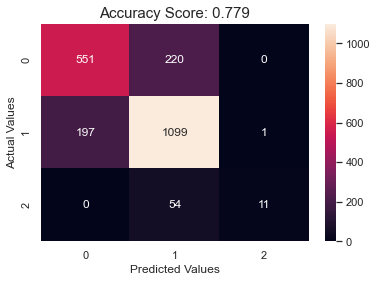

              precision    recall  f1-score   support

           0       0.74      0.71      0.73       771
           1       0.80      0.85      0.82      1297
           2       0.92      0.17      0.29        65

    accuracy                           0.78      2133
   macro avg       0.82      0.58      0.61      2133
weighted avg       0.78      0.78      0.77      2133



In [128]:
X = wines[['fixed_acidity','volatile_acidity','citric_acid','residual_sugar','chlorides',
           'free_sulfur_dioxide','total_sulfur_dioxide','density','pH','sulphates','alcohol']]

y = wines['qual_labels']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=40)

X_train_scaled = StandardScaler().fit_transform(X_train)
X_test_scaled = StandardScaler().fit_transform(X_test)

xgb = XGBClassifier()
xgb.fit(X_train_scaled, y_train)

train_accuracy = xgb.score(X_train_scaled, y_train)
test_accuracy = xgb.score(X_test_scaled, y_test)
print('One-vs-rest', '-'*35, 
      'Accuracy in Train Group   : {:.2f}'.format(train_accuracy), 
      'Accuracy in Test  Group   : {:.2f}'.format(test_accuracy), sep='\n')

predictions = xgb.predict(X_test_scaled)
score = round(accuracy_score(y_test, predictions), 3)
cm1 = cm(y_test, predictions)
sns.heatmap(cm1, annot=True, fmt=".0f")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Accuracy Score: {0}'.format(score), size = 15)
plt.show()

print(classification_report(y_test, predictions))

###### Support vector machines

One-vs-rest
-----------------------------------
Accuracy in Train Group   : 0.77
Accuracy in Test  Group   : 0.75


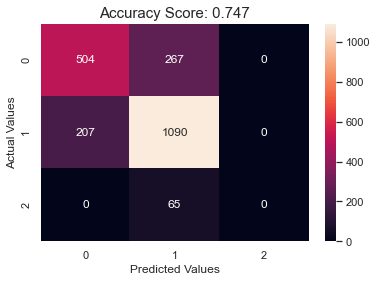

              precision    recall  f1-score   support

           0       0.71      0.65      0.68       771
           1       0.77      0.84      0.80      1297
           2       0.00      0.00      0.00        65

    accuracy                           0.75      2133
   macro avg       0.49      0.50      0.49      2133
weighted avg       0.72      0.75      0.73      2133



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [129]:
X = wines[['fixed_acidity','volatile_acidity','citric_acid','residual_sugar','chlorides',
           'free_sulfur_dioxide','total_sulfur_dioxide','density','pH','sulphates','alcohol']]

y = wines['qual_labels']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=40)

X_train_scaled = StandardScaler().fit_transform(X_train)
X_test_scaled = StandardScaler().fit_transform(X_test)

svm = SVC()
svm.fit(X_train_scaled, y_train)

train_accuracy = svm.score(X_train_scaled, y_train)
test_accuracy = svm.score(X_test_scaled, y_test)

print('One-vs-rest', '-'*35, 
      'Accuracy in Train Group   : {:.2f}'.format(train_accuracy), 
      'Accuracy in Test  Group   : {:.2f}'.format(test_accuracy), sep='\n')

predictions = svm.predict(X_test_scaled)
score = round(accuracy_score(y_test, predictions), 3)

cm1 = cm(y_test, predictions)
sns.heatmap(cm1, annot=True, fmt=".0f")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Accuracy Score: {0}'.format(score), size = 15)
plt.show()

print(classification_report(y_test, predictions))

###### Deep Neural Network

The most simple neural network is the "perceptron", which, in its simplest form, consists of a single neuron. The perceptrons only work with numerical data, so, you should convert any nominal data into a numerical format.

The the perceptron has a important limitation, it could only represent linear separations between classes. To overcome this we can use the multi-layer perceptron overcomes that can be represent more complex decision boundaries.

Multi-layer perceptrons are also known as "feed-forward neural networks". These are more complex networks as they consist of multiple neurons that are organized in layers. The number of layers is usually limited to two or three, but theoretically, there is no limit!

Among the layers, you can distinguish an input layer, hidden layers and an output layer. Multi-layer perceptrons are often fully connected. This means that there's a connection from each perceptron in a certain layer to each perceptron in the next layer. Even though the connectedness is no requirement, this is typically the case.

One of the most powerful and easy-to-use Python libraries for developing and evaluating deep learning models is Keras. It wraps the efficient numerical computation libraries Theano and TensorFlow. The advantage of this is mainly that you can get started with neural networks in an easy and fun way. A quick way to get started is to use the Keras Sequential model: it's a linear stack of layers. You can easily create the model by passing a list of layer instances to the constructor, which you set up by running model = Sequential().

So, let's go and create our DNN classifier of type wines in Keras with TensorFlow:


In [200]:
X = wines[['fixed_acidity','volatile_acidity','citric_acid','residual_sugar','chlorides',
           'total_sulfur_dioxide','pH','sulphates','alcohol']]

y = wines['qual_labels']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=40)

X_train_scaled = StandardScaler().fit_transform(X_train)
X_test_scaled = StandardScaler().fit_transform(X_test)

nn = Sequential()
nn.add(Dense(32, activation='relu', input_shape=(9,)))
nn.add(Dense(16, activation='relu'))
nn.add(Dense(1, activation='sigmoid'))


In [201]:
nn.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_82 (Dense)             (None, 32)                320       
_________________________________________________________________
dense_83 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_84 (Dense)             (None, 1)                 17        
Total params: 865
Trainable params: 865
Non-trainable params: 0
_________________________________________________________________


In [205]:
nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'mse'])

In [206]:
nn.fit(X_train_scaled, y_train, epochs=40, batch_size=50, shuffle=True)

Epoch 1/40
87/87 [==============================] - 0s 803us/step - loss: 0.5916 - accuracy: 0.6206 - mse: 0.2643
Epoch 2/40
87/87 [==============================] - 0s 805us/step - loss: 0.4687 - accuracy: 0.7090 - mse: 0.2182
Epoch 3/40
87/87 [==============================] - 0s 923us/step - loss: 0.4290 - accuracy: 0.7194 - mse: 0.2081
Epoch 4/40
87/87 [==============================] - 0s 805us/step - loss: 0.4095 - accuracy: 0.7236 - mse: 0.2046
Epoch 5/40
87/87 [==============================] - 0s 803us/step - loss: 0.3942 - accuracy: 0.7277 - mse: 0.2026
Epoch 6/40
87/87 [==============================] - 0s 805us/step - loss: 0.3817 - accuracy: 0.7279 - mse: 0.2014
Epoch 7/40
87/87 [==============================] - 0s 806us/step - loss: 0.3676 - accuracy: 0.7305 - mse: 0.1998
Epoch 8/40
87/87 [==============================] - 0s 921us/step - loss: 0.3567 - accuracy: 0.7296 - mse: 0.1995
Epoch 9/40
87/87 [==============================] - 0s 1ms/step - loss: 0.3423 - accurac

In [207]:
train_accuracy = nn.evaluate(X_train_scaled, y_train)
print(train_accuracy)

136/136 [==============================] - 0s 588us/step - loss: -5.1795 - accuracy: 0.7326 - mse: 0.2043
[-5.179534435272217, 0.7325634956359863, 0.20427526533603668]


In [208]:
test_accuracy = nn.evaluate(X_test_scaled, y_test)
print(test_accuracy)

67/67 [==============================] - 0s 598us/step - loss: -2.9757 - accuracy: 0.7079 - mse: 0.2134
[-2.975698709487915, 0.7079231142997742, 0.21340565383434296]


Conlusion: We have been able to demonstrate the Exploratory data analysis, along with handling missing values, outliers, skewed data using boxcox transformation, Alsong modeling and evaluation metrics for models.

We will be learning even more int he future. We will also start using Julia language for coding alongside python in future 